In [1]:
# New analysis notebook, started Jan 6 2025, for looking at dipolarization regions

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import re
import pandas as pd
from matplotlib.patches import Wedge
from datetime import datetime
import matplotlib.dates as md
import tecplot as tp
from tecplot.constant import PlotType
from scipy.optimize import curve_fit
import math
from scipy.fft import fft, fftfreq
from itertools import zip_longest
from collections import defaultdict
import os
from astropy.time import Time
import juliandate
from datetime import datetime, timedelta
import pickle

In [42]:
# Define constants
amu = 1.67e-27
m_p = amu
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440
M_M = -200.9 #nT R_M^3
e = 1.602e-19

In [3]:
# Define functions

# Load a PDS dataset and return a big numpy array with all the data
def read_mag(path,highres=False):
    # First, get all the files in the directory
    all_files = [f for f in listdir(path) if isfile(join(path, f))]
    # Then use regex to pick out the .tab file
    for i in all_files:
        match = re.search(".*\.TAB",i)
        if match != None:
            file = str(path+"/"+i)
    if highres:
        print("Reading highres data:",path)
        colnames=['year','DAY_OF_YEAR','hour','minute','second','TIME_TAG','X','Y','Z','B_x','B_y','B_z']
    else:
        print("Reading lowres data:",path)
        colnames=['year','DAY_OF_YEAR','hour','minute','second','TIME_TAG','NAVG','X','Y','Z','B_x','B_y','B_z','DBX','DBY','DBZ']
    df = pd.read_csv(file, delimiter=r"\s+", names=colnames, header=None)
    return df

# Read in GRS and do the huge amount of work required to turn the data into something usable. summing states how many channels to summing over (i.e summing=100 means 100*0.01ms = 1s)

def read_GRS(path,summing = 6000):
    # Define the dataframe we actually want/need
    template = {'timestamp': [], 'counts': [] } #'year': [], 'month': [], 'day': [], 'hour': [], 'minute': [], 'second': [], 'counts': []}
    GRS = pd.DataFrame(data=template)
    # First, get all the subfolders (representing months)
    # months = [ f.path for f in os.scandir(path) if f.is_dir() ]
    # Iterate through all months
    # for month_dir in months: 
    all_files = [f for f in listdir(path) if isfile(join(path, f))]
    # Iterate through all .tab files
    for i in all_files:
        match = re.search(".*\.tab",i)
        if match != None:
            # Get filename
            file = str(path+i)
            print("reading file:",file)
            # Read in data as temp, ugly dataframe
            data = pd.read_csv(file, delimiter = r"\s+", header=None)
            #print(data)
            # Step through each row, representing 1800s of data (which for some reason is stored as many columns rather than subsequent rows)
            for batch in range(len(data[1])):
                if batch%100==0:
                    print("processing batch#",batch)
                # Convert to a useable time system
                ye,mo,da,ho,mi,se,micro = juliandate.to_gregorian(data[1][batch]) #(note micro is microseconds, which we subsequently convert to milliseconds)
                # Carefully structure the time object
                base_time = datetime(year=ye, month=mo, day=da, hour=ho, minute=mi, second=int(se), microsecond=int(micro))
                for channel in np.arange(91,16425-summing,summing): # This loops over each n=summing channels to group together. Skip first 50.
                    sum_counts = 0
                    zeros = 0
                    for sum_channel in range(summing):
                        sum_counts+=data[(channel+sum_channel)][batch]
                        if data[(channel+sum_channel)][batch]==0:
                            zeros+=1
                    # Create a timedelta for the milliseconds
                    delta = timedelta(milliseconds=int((channel-41)*10))
                    # Add the timedelta to the base time
                    new_time = base_time + delta
                    #print("base time:",base_time)
                    #print("new time:",new_time)
                    # Sae
                    if zeros==0: # Quick fix to deal with the complicated fact that new batches are started before old one finished
                        GRS.loc[len(GRS)] = [new_time,sum_counts]
                    #GRS.loc[len(GRS)] = [new_time,ye,mo,da,new_time.hour,new_time.minute,new_time.second + new_time.microsecond / 1_000_000,sum_counts]
    return GRS

# Read in GRS and do the huge amount of work required to turn the data into something usable. summing states how many channels to summing over (i.e summing=100 means 100*0.01ms = 1s)
def read_GRS2(path):
    # Define the dataframe we actually want/need
    template = {'timestamp': [], 'counts': [] } #'year': [], 'month': [], 'day': [], 'hour': [], 'minute': [], 'second': [], 'counts': []}
    GRS = pd.DataFrame(data=template)
    # First, get all the subfolders (representing months)
    months = [ f.path for f in os.scandir(path) if f.is_dir() ]
    # Iterate through all months
    for month_dir in months: 
        all_files = [f for f in listdir(month_dir) if isfile(join(month_dir, f))]
        # Iterate through all .tab files
        for i in all_files:
            match = re.search(".*\.tab",i)
            if match != None:
                # Get filename
                file = str(month_dir+"/"+i)
                # Read in data as temp, ugly dataframe
                data = pd.read_csv(file, delimiter = r"\s+", header=None)
                #print(data)
                # Step through each row, representing 1800s of data (which for some reason is stored as many columns rather than subsequent rows)
                for batch in range(len(data[1])):
                    if batch%100==0:
                        print("processing batch#",batch)
                    # Convert to a useable time system
                    ye,mo,da,ho,mi,se,micro = juliandate.to_gregorian(data[1][batch]) #(note micro is microseconds, which we subsequently convert to milliseconds)
                    base_time = datetime(year=ye, month=mo, day=da, hour=ho, minute=mi, second=int(se), microsecond=int(micro))
                    GRS.loc[len(GRS)] = [base_time,data[16424][batch]]
    return GRS
        

# Compute dipole field Bz
def Bz_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: Bz at each point
    return - 200.9 * (3*(z_array-0.2)**2 - (x_array**2+y_array**2+(z_array-0.2)**2))/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

# Read in magnetic field data from a simulation file
def get_B_from_sim(filename,df):
    # This function takes the path to a 3d tecplot file and a dataframe with X,Y,Z
    # It returns the simulated B field at those points, which are added to the dataframe
    
    # Load data
    tp.session.connect()
    tp.new_layout()
    dataset = tp.data.load_tecplot(filename)
    fr = tp.active_frame()
    fr.plot_type = PlotType.Cartesian3D

    # See if there is already model data to overwrite:
    if "B_x_sim" in df:
        return df
    #else:
    # Define empty arrays
    Bx = np.zeros_like(df["X"])
    By = np.zeros_like(df["X"])
    Bz = np.zeros_like(df["X"])

    # Pull data for each. Also pulls the one point before start_time, to fix the gradients.
    for i in range(len(df)):
        result = tp.data.query.probe_at_position(df["X"].iloc[i]/R_M,df["Y"].iloc[i]/R_M,df["Z"].iloc[i]/R_M)
        if result is not None:
            Bx[i],By[i],Bz[i] = result[0][3:6] # Make sure to check that 3:6 corresponds to the B data!
        # If this is outside the bounds of the simulation data, it will be set to 0

    # Update values in df or add new columns
    df.insert(len(df.columns), "B_x_sim",Bx)
    df.insert(len(df.columns), "B_y_sim",By)
    df.insert(len(df.columns), "B_z_sim",Bz)
    
    return df

# Return a df of just the data around the current sheet centers, using either a fixed z window, or based on the Bx reversal
def extract_cs(df,criteria = "z",threshold = 0.1):
    # Extract all the data within the current sheet, as defined by the criteria
    # Critera: z - choose all points within +- threshold of z = 0.2 R_M
    if criteria == "z":
        df_slice = df[(df['Z']/R_M>=(0.2-threshold)) & (df['Z']/R_M<=(0.2+threshold)) & (df['X']<0)].reset_index()
        cs_pass = [0]
        for index in range(1,len(df_slice)):
            if df_slice["TIME_TAG"][index]-df_slice["TIME_TAG"][index-1]>1.1:
                cs_pass.append(cs_pass[index-1]+1)
            else:
                cs_pass.append(cs_pass[index-1])
        df_slice.insert(len(df_slice.columns), "cs_pass",cs_pass)

        return df_slice

    if criteria == "Bx":
        # First, downselected to the regions near the current sheet. Add cs_pass to this area
        df_slice = df[(df['Z']/R_M>=(0.2-3*threshold)) & (df['Z']/R_M<=(0.2+3*threshold)) & (df['X']<0)]
        cs_pass = [0]
        count=0
        prev_index = df_slice.index.tolist()[0]
        for index in df_slice.index.tolist()[1:]:
            if index - prev_index >1: # If we have reached a skip in the indexing
                count+=1
            cs_pass.append(count)
            prev_index = index
        df_slice.insert(len(df_slice.columns), "cs_pass",cs_pass)
        # Iterate through each pass to further filter
        all_indices = np.array(())
        for pass_num in np.unique(df_slice["cs_pass"]):
            #print("Looking for center of cs pass",pass_num)
            df_pass = df_slice[df_slice["cs_pass"]==pass_num]
            # Then find where Bx is minimum and is negative before and positive after
            # Take the square of the values so that its just magnitude
            Bx_vals = np.unique(df_pass["B_x"]**2)
            # Iterate through each value, from smallest to largest until a suitable value is found
            count=0
            while count>=0:
                index = df_pass.index[df_pass['B_x']**2 == Bx_vals[count]][0]
                if (df_slice["B_x"][index-1]<0) and (df_slice["B_x"][index+1]>0):
                    #print("Match! CS found for pass",pass_num,'at Z =',df_pass["Z"][index]/R_M)
                    # If this condition is met, find the indices corresponding to this
                    indices = df_pass.index[(df_pass["Z"] - df_pass["Z"][index])**2 < (threshold*R_M)**2].tolist() # Factor of 2 to increase how much data we return
                    all_indices = np.concatenate((all_indices, indices), axis=None)
                    count=-1
                else:
                    count+=1   
        return df_slice.loc[all_indices]

# All calculations of secondary terms are done here
def calculate_terms(df,use_model_data=False):
    # Compute spherical coords
    R = np.sqrt(df['X']**2+df['Y']**2+(df['Z']-0.2*R_M)**2) # km
    
    # Compute magnetic field strength
    B_mag = np.sqrt(df['B_x']**2+df['B_y']**2+df['B_z']**2) # nT

    # Compute magnetic pressure
    P_mag = B_mag**2/(2*mu_0)*1e-9 # nPa

    # Compute dipole field, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
    B_xdip = 3*M_M * df['X']/R_M * (df['Z']-0.2*R_M)/R_M/(R/R_M)**5
    B_ydip = 3*M_M * df['Y']/R_M * (df['Z']-0.2*R_M)/R_M/(R/R_M)**5
    B_zdip = M_M * (3*((df['Z']-0.2*R_M)/R_M)**2-(R/R_M)**2)/(R/R_M)**5
    B_dip = np.sqrt(B_xdip**2+B_ydip**2+B_zdip**2)
    P_magdip = B_dip**2/(2*mu_0)*1e-9 # Magnetic pressure of dipole field
    
    # Compute local lat/time
    lat = np.arctan(df['Z']/np.sqrt(df['X']**2+df['Y']**2))*180/np.pi
    phi = np.arctan(df['Y']/df['X'])
    local_time = phi*12/np.pi + 12 

    # Compute timestamp
    year = df['year'].to_numpy()
    daynum = df['DAY_OF_YEAR'].to_numpy()
    month_ls = []
    day_ls = []
    for i in range(len(year)):
        date = datetime.strptime(str(year[i]) + "-" + str(daynum[i]), "%Y-%j").strftime("%m-%d-%Y")
        month_ls.append(date[0:2])
        day_ls.append(date[3:5])

    # Pull MHD result values, saving timestamp first so it knows how to read the right times
    df.insert(len(df.columns), "day",day_ls)
    df.insert(len(df.columns), "month",month_ls)
    df.insert(0, "timestamp", pd.to_datetime(df[['year','day','month','hour','minute','second']]))
    if use_model_data:
        df = get_B_from_MHD(GM_output,df,start_time,end_time,"GM")
        B_xMHD = df['B_xMHD']
        B_yMHD = df['B_yMHD']
        B_zMHD = df['B_zMHD']
        B_MHD = np.sqrt(B_xMHD**2+B_yMHD**2+B_zMHD**2)
        P_magMHD = B_MHD**2/(2*mu_0)*1e-9 # Magnetic pressure of MHD result
    
    # Compute gradients:
    # Step through each cell and compute dx,dy,dz. We skip the first cell.
    dx=[0]
    dy=[0]
    dz=[0]
    dBx=[0]
    dBy=[0]
    dBz=[0]
    dB_xdip=[0]
    dB_ydip=[0]
    dB_zdip=[0]
    dP_mag=[0]
    dP_magdip=[0]
    if use_model_data:
        dB_xMHD=[0]
        dB_yMHD=[0]
        dB_zMHD=[0]
        dP_magMHD=[0]
    for i in range(1,len(df)):
        dx.append(df['X'][i]-df['X'][i-1]) #dx
        dy.append(df['Y'][i]-df['Y'][i-1])
        dz.append(df['Z'][i]-df['Z'][i-1])
        dBx.append(df['B_x'][i]-df['B_x'][i-1]) #dBx
        dBy.append(df['B_y'][i]-df['B_y'][i-1])
        dBz.append(df['B_z'][i]-df['B_z'][i-1])
        dB_xdip.append(B_xdip[i]-B_xdip[i-1]) #dBx of dipole field
        dB_ydip.append(B_ydip[i]-B_ydip[i-1])
        dB_zdip.append(B_zdip[i]-B_zdip[i-1])
        dP_mag.append(P_mag[i]-P_mag[i-1]) #dP_mag
        dP_magdip.append(P_magdip[i]-P_magdip[i-1]) #dP_mag of dipole field
        if use_model_data:
            dB_xMHD.append(B_xMHD[i]-B_xMHD[i-1]) #dBx of MHD result
            dB_yMHD.append(B_yMHD[i]-B_yMHD[i-1])
            dB_zMHD.append(B_zMHD[i]-B_zMHD[i-1])
            dP_magMHD.append(P_magMHD[i]-P_magMHD[i-1]) #dP_mag of MHD result
        # Set the 0th element equal to the first
        if i==1:
            dx[0] = dx[i]
            dy[0] = dy[i]
            dz[0] = dz[i]
            dBx[0] = dBx[i]
            dBy[0] = dBy[i]
            dBz[0] = dBz[i]
            dB_xdip[0] = dB_xdip[i]
            dB_ydip[0] = dB_ydip[i]
            dB_zdip[0] = dB_zdip[i]
            dP_mag[0] = dP_mag[i]
            dP_magdip[0] = dP_magdip[i]
            if use_model_data:
                dB_xMHD[0] = dB_xMHD[i]
                dB_yMHD[0] = dB_yMHD[i]
                dB_zMHD[0] = dB_zMHD[i]
                dP_magMHD[0] = dP_magMHD[i]
    # Save to df
    df.insert(len(df.columns), "lat",lat)
    df.insert(len(df.columns), "local_time",local_time) 
    df.insert(len(df.columns), "B_mag",B_mag)
    df.insert(len(df.columns), "P_mag",P_mag)
    df.insert(len(df.columns), "B_xdip",B_xdip)
    df.insert(len(df.columns), "B_ydip",B_ydip)
    df.insert(len(df.columns), "B_zdip",B_zdip)
    df.insert(len(df.columns), "B_dip",B_dip)
    df.insert(len(df.columns), "P_magdip",P_magdip)
    df.insert(len(df.columns), "dX",dx)
    df.insert(len(df.columns), "dY",dy)
    df.insert(len(df.columns), "dZ",dz)
    df.insert(len(df.columns), "dB_x",dBx)
    df.insert(len(df.columns), "dB_y",dBy)
    df.insert(len(df.columns), "dB_z",dBz)
    df.insert(len(df.columns), "dB_xdip",dB_xdip)
    df.insert(len(df.columns), "dB_ydip",dB_ydip)
    df.insert(len(df.columns), "dB_zdip",dB_zdip)
    df.insert(len(df.columns), "dP_mag",dP_mag)
    df.insert(len(df.columns), "dP_magdip",dP_magdip)
    if use_model_data:
        df.insert(len(df.columns), "B_MHD",B_MHD)
        df.insert(len(df.columns), "P_magMHD",P_magMHD)
        df.insert(len(df.columns), "dB_xMHD",dB_xMHD)
        df.insert(len(df.columns), "dB_yMHD",dB_yMHD)
        df.insert(len(df.columns), "dB_zMHD",dB_zMHD)
        df.insert(len(df.columns), "dP_magMHD",dP_magMHD)
    
    # Make corrections
    df['local_time'][df['X']<0] = 24 - df['local_time'][df['X']<0]
    return df

def plot_cs_passes4(df,df_cs):
    # Makes a nice plot of the current sheet crossings, like Jim's

    # Determine which paths are in front of the planet vs. behind
    df_noview =df[(df['X']>0)]
    df_inview =df[(df['X']<0)]# & (df['timestamp']>pd.to_datetime("2015-04-01 21:00:00")) & (df['timestamp']<pd.to_datetime("2015-04-03 13:00:00"))]
    
    # Define figure and patches
    fig, ax = plt.subplots(ncols=1,figsize=(7,5))
    p0 = plt.Circle((0, 0), 1, color='black')
    p1 = plt.Circle((0, 0), 0.99, color='lightgrey')

    plot0=ax.scatter(df_noview["Y"]/R_M,df_noview["Z"]/R_M,s=0.05,color='black')
    
    # Put in the planet
    ax.add_artist(p0)
    ax.add_artist(p1)

    # plot
    plot1=ax.scatter(df_inview["Y"]/R_M,df_inview["Z"]/R_M,s=0.05,color='black')#,c=list((df_inview['DAY_OF_YEAR']-np.min(df_inview['DAY_OF_YEAR']))),
    ax.plot([-1,1],[0.2,0.2],linestyle="dashed",color="black")
    for pass_num in range(np.max(df_cs['cs_pass'])+1):
        df_pass = df_cs[(df_cs['cs_pass']==pass_num)]
        midpoint = [df_pass["Y"][df_pass.index[len(df_pass.index)//2]]/R_M, df_pass["Z"][df_pass.index[len(df_pass.index)//2]]/R_M]
        plot2=ax.scatter(df_pass["Y"]/R_M,df_pass["Z"]/R_M,s=2,c = df_pass["B_z"]-df_pass["B_zdip"],vmin=-50,vmax=50,cmap='bwr')
        ax.plot([midpoint[0]-0.008,midpoint[0]+0.008],[midpoint[1],midpoint[1]],lw=1.8,color="yellow")
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1,1)
    ax.set_ylim(-0.75,1.25)
    ax.invert_xaxis()
    ax.set_xlabel("Y [$R_M$]")
    ax.set_ylabel("Z [$R_M$]")
    clb1 = fig.colorbar(plot2, ax=ax)
    clb1.ax.set_title("$B_{z,obs}/B_{z,dip}$")
    #plt.savefig("MESSENGER_orbits.png")

def plot_Bz_minus_Bzdip(df_cs):
    # For a df_cs dataframe, generate a plot of Bz1=Bz-Bzdip for each pass to help identify DR events
    count=0
    for i in np.unique(df_cs["cs_pass"]): #[5,10,27,32]: 
        indices = np.where(df_cs["cs_pass"]==i)[0]
        plt.figure(figsize=(10,6))
        #plt.plot(df_cs['timestamp'][indices],df_cs["B_mag"][indices],color="black")
        #plt.plot(df_cs['timestamp'][indices],df_cs["B_dip"][indices],color="black",linestyle="dashed")
        plt.plot(df_cs['Z'][indices],df_cs["B_z"][indices]-df_cs["B_zdip"][indices],color="black")
        plt.plot(df_cs['Z'][indices],df_cs["B_zdip"][indices]*0,color="black",linestyle="dashed")
        plt.title(str("CS pass: "+str(i)+"\n starting on: "+str(df_cs["timestamp"][indices[0]])))
        plt.ylim(-100,100)
        if np.max(df_cs["B_z"][indices]-df_cs["B_zdip"][indices])>0:
            count+=1
        plt.show()
        plt.close()

def extract_DR_passes(df_cs,max_DR_width = 0.4):
    # For a df_cs dataframe, generate a plot of Bz1=Bz-Bzdip for each pass to help identify DR events
    count=0
    passes = {}
    # Loop through all the current sheet passes
    for i in np.unique(df_cs["cs_pass"]): #[5,10,27,32]: 
        # Work out the indices which  correspond to the dataframe entries of this flyby
        indices = np.where(df_cs["cs_pass"]==i)[0]
        # Work out the index of the cs center
        midpoint = indices[len(indices)//2]
        # Work out the indices of the max and min Z value by which Bz1<0 for DR classification 
        upper_indices = df_cs['Z'][indices].index[df_cs['Z'][indices] >= df_cs['Z'][midpoint]+max_DR_width*R_M/2].tolist()
        lower_indices = df_cs['Z'][indices].index[df_cs['Z'][indices] <= df_cs['Z'][midpoint]-max_DR_width*R_M/2].tolist()
        # In general, we don't know if we are flying south to north or vice versa; this section deals with that
        if max(upper_indices)>max(lower_indices): # South to north case
            izmax = upper_indices[0]
            izmin = lower_indices[-1]
        else:
            izmax = upper_indices[-1]
            izmin = lower_indices[0]

        # Filter 1: Bz1>0 at cs center
        if (df_cs["B_z"][midpoint]>df_cs["B_zdip"][midpoint]):
            #print("cs pass",i,"is enhanced at current sheet center ("+str(df_cs['Z'][midpoint]/R_M)+")")
            # Filter 2: Bz1<0 at max width edges
            if (df_cs["B_z"][izmax]<df_cs["B_zdip"][izmax]) and (df_cs["B_z"][izmin]<df_cs["B_zdip"][izmin]):
                # Filter 3: Check it only peaks 1-2 times in this range
                peak_count = 0
                for j in np.arange(1+min(izmin,izmax),max(izmin,izmax)):
                    if (df_cs["B_z"][j-1]<df_cs["B_zdip"][j-1]) and (df_cs["B_z"][j]>df_cs["B_zdip"][j]): # i.e if this index represents a change from Bz1<0 to Bz1>1, this is the start of a peak
                        peak_count+=1
                if peak_count<3:
                    passes[i] = indices
                '''
                # Filter 3: Bz1<0 within max_DR_width/2 of the cs center (currently redundant)
                if max(upper_indices)>max(lower_indices): # South to north case
                    if (df_cs["B_z"][midpoint:izmax]-df_cs["B_zdip"][midpoint:izmax]).min()<0 and (df_cs["B_z"][izmin:midpoint]-df_cs["B_zdip"][izmin:midpoint]).min()<0:
                        #print("cs pass",i,"also has the Bz1 decrease on the edges! It's a DR")
                        passes.append(i)
                else: 
                    if (df_cs["B_z"][izmax:midpoint]-df_cs["B_zdip"][izmax:midpoint]).min()<0 and (df_cs["B_z"][midpoint:izmin]-df_cs["B_zdip"][midpoint:izmin]).min()<0:
                        #print("cs pass",i,"also has the Bz1 decrease on the edges! It's a DR")
                        passes.append(i)
                '''
            
            #plt.plot(df_cs['timestamp'][indices],df_cs["B_mag"][indices],color="black")
        #plt.plot(df_cs['timestamp'][indices],df_cs["B_dip"][indices],color="black",linestyle="dashed")
        if i in passes:
            color='blue'
        else:
            color='red'
            
        #print("Average R for this DR:",np.mean(np.sqrt(df_cs["X"][indices]**2+df_cs["Y"][indices]**2+df_cs["Z"][indices]**2)/R_M))
        plt.figure(figsize=(10,6))
        plt.plot(df_cs['timestamp'][indices],df_cs["B_z"][indices]-df_cs["B_zdip"][indices],color=color)
        plt.plot(df_cs['timestamp'][indices],df_cs["B_zdip"][indices]*0,color='black')
        plt.plot([df_cs['timestamp'][midpoint],df_cs['timestamp'][midpoint]],[-100,100],color='black',linestyle="dashed")
        plt.plot([df_cs['timestamp'][izmax],df_cs['timestamp'][izmax]],[-100,100],color='black',linestyle="dotted")
        plt.plot([df_cs['timestamp'][izmin],df_cs['timestamp'][izmin]],[-100,100],color='black',linestyle="dotted")
        plt.title(str("CS pass: "+str(i)+"\n starting on: "+str(df_cs["timestamp"][indices[0]])))
        plt.ylim(-100,100)
        if np.max(df_cs["B_z"][indices]-df_cs["B_zdip"][indices])>0:
            count+=1
        plt.show()
        plt.close()

    return passes

def plot_GRS_and_DR(df_cs,GRS,DR_dict):
    for DR in DR_dict.keys():
        indices = DR_dict[DR]
        GRS_indices = np.where((GRS["timestamp"]>df_cs["timestamp"][indices[0]]) & (GRS["timestamp"]<df_cs["timestamp"][indices[-1]]))[0]
        midpoint = indices[len(indices)//2]
        fig, ax = plt.subplots(figsize=(10,6))
        #ax2 = ax.twinx()
        ax.plot(df_cs['timestamp'][indices],df_cs["B_z"][indices]-df_cs["B_zdip"][indices],color='black')
        ax.plot(GRS['timestamp'][GRS_indices],GRS["counts"][GRS_indices],color='blue')
        #ax2.yaxis.label.set_color('blue')
        #ax2.tick_params(axis ='y', labelcolor = "blue")
        ax.plot(df_cs['timestamp'][indices],df_cs["B_zdip"][indices]*0,color='black')
        ax.plot([df_cs['timestamp'][midpoint],df_cs['timestamp'][midpoint]],[-100,100],color='black',linestyle="dashed")
        ax.set_title(str("CS pass: "+str(DR)+"\n starting on: "+str(df_cs["timestamp"][indices[0]])))
        ax.set_ylim(-100,100)
        #ax2.set_ylim(-10000,10000)
        plt.show()
        plt.close()

Text(0.5, 0, 'Timestamp')

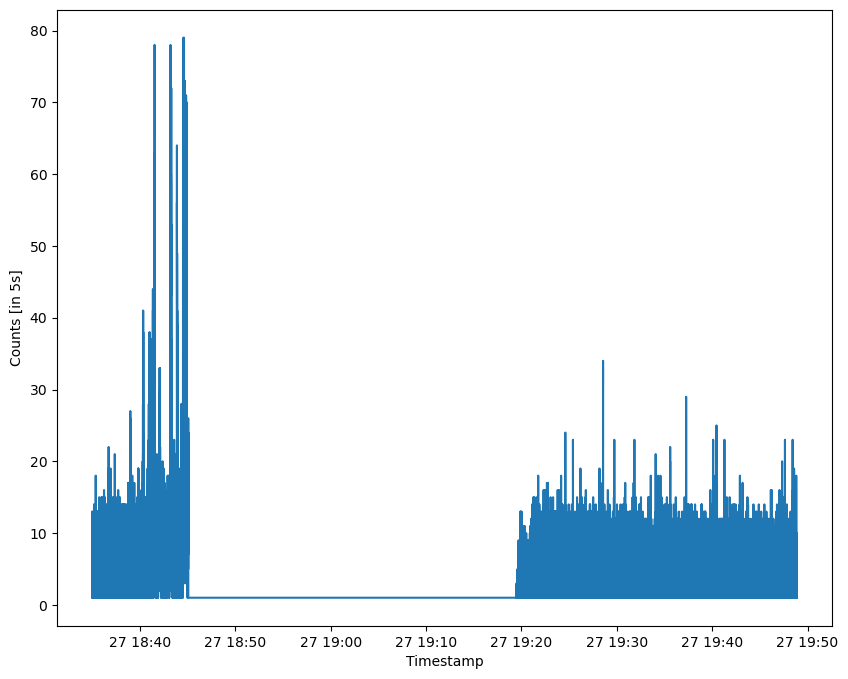

In [547]:
start_time = "2015-03-27 18:35:00"
stop_time = "2015-03-27 19:50:00"
indices = np.where((GRS["timestamp"]>start_time) & (GRS["timestamp"]<stop_time))[0]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
ax.plot(GRS['timestamp'][indices],GRS['counts'][indices])
ax.set_ylabel("Counts [in 5s]")
ax.set_xlabel("Timestamp")

In [ ]:
# Begin analysis

# Define directories for MAG data
dir = "/Users/atcushen/Documents/MercuryModelling/MAG_lowres/"
folder_ls = ["2015-03-26","2015-03-27","2015-03-28","2015-03-29","2015-03-30","2015-03-31",
             "2015-04-01","2015-04-02","2015-04-03","2015-04-04","2015-04-05","2015-04-06",
             "2015-04-07","2015-04-08","2015-04-09"]
# Define simulation data for comparison
sim_output = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-3e/3d_fluid_region0_0_t00000100_n00026179_amrex.plt"

# Define "df", which is the dataframe storing all the MAG data
df = read_mag(str(dir+folder_ls[0]))
for day in folder_ls[1:]:
    df = pd.concat([df,read_mag(str(dir+day))], ignore_index=True)

# Refine df_cs, which is just the data around the current sheet crossings
df_cs = extract_cs(df,criteria = 'z', threshold = 0.5)

In [90]:
temp=df_cs[df_cs["cs_pass"]==10]
temp = get_B_from_sim(sim_output,temp)

Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.


(-0.1, 0.5)

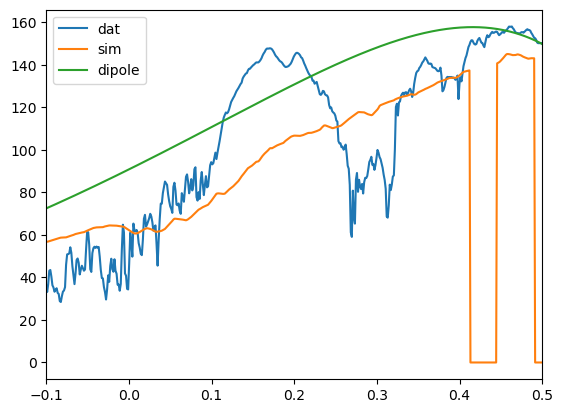

In [92]:
plt.plot(temp["Z"]/R_M,temp["B_z"],label='dat')
plt.plot(temp["Z"]/R_M,temp["B_z_sim"],label='sim')
plt.plot(temp["Z"]/R_M,Bz_dip(temp["X"]/R_M,temp["Y"]/R_M,temp["Z"]/R_M),label='dipole')
plt.legend()
plt.xlim(-0.1,0.5)

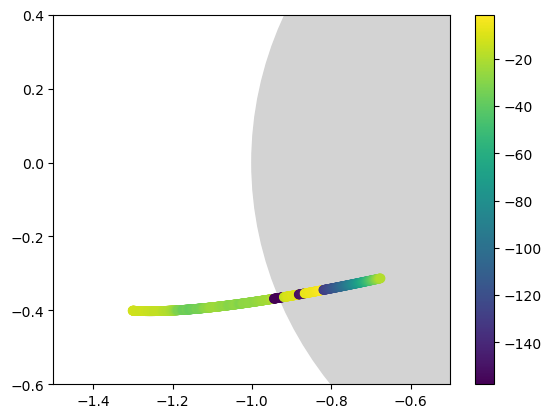

In [93]:
fig,ax = plt.subplots()
outer = plt.Circle((0, 0), 1, color='lightgray') 
ax.add_patch(outer)
plot=ax.scatter(temp["X"]/R_M,temp["Y"]/R_M,c=temp["B_z_sim"]-Bz_dip(temp["X"]/R_M,temp["Y"]/R_M,temp["Z"]/R_M))
ax.set_xlim(-1.5,-0.5)
ax.set_ylim(-0.6,0.4)
fig.colorbar(plot)

Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-20
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-21
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-22
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-23
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-23
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-25
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-26
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-27
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-28
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-29
Reading lowres data: /Users/atcushen/Documents/MercuryModelling/MAG_lowres/2015-03-30
Reading lowres data: /Users/atcushen/Documents/Mercury

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12470/3687256897.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['local_time'][df['X']<0] = 24 - df['local_time'][df['X']<0]


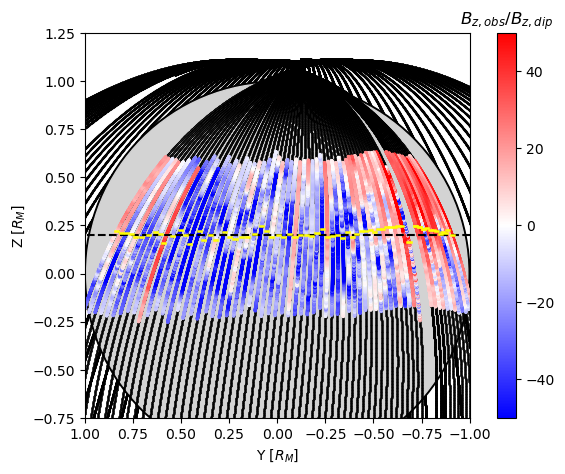

In [119]:
# Define directories for MAG data
dir = "/Users/atcushen/Documents/MercuryModelling/MAG_lowres/"
#folder_ls = ["2014-9-30","2014-10-01","2014-10-02","2014-10-03","2014-10-04","2014-10-05","2014-10-06","2014-10-07",
#            "2014-10-08","2014-10-09","2014-10-10","2014-10-11","2014-10-12","2014-10-13","2014-10-14","2014-10-15",
#            "2014-10-16","2014-10-17"]

#folder_ls = ["2014-12-23","2014-12-24","2014-12-25","2014-12-26","2014-12-27","2014-12-28","2014-12-29","2014-12-30",
#             "2014-12-31","2015-01-01","2015-01-02","2015-01-03","2015-01-04","2015-01-05","2015-01-06","2015-01-07",
#             "2015-01-08","2015-01-09","2015-01-10","2015-01-11","2015-01-12","2015-01-13","2015-01-14","2015-01-15",
#             "2015-01-16"]

folder_ls = ["2015-03-20","2015-03-21","2015-03-22","2015-03-23","2015-03-23","2015-03-25",
             "2015-03-26","2015-03-27","2015-03-28","2015-03-29","2015-03-30","2015-03-31",
             "2015-04-01","2015-04-02","2015-04-03","2015-04-04","2015-04-05","2015-04-06",
             "2015-04-07","2015-04-08","2015-04-09","2015-04-10","2015-04-11","2015-04-12"]
             
# Define "df", which is the dataframe storing all the MAG data
df = read_mag(str(dir+folder_ls[0]))
for day in folder_ls[1:]:
    df = pd.concat([df,read_mag(str(dir+day))], ignore_index=True)

# Define df_cs, which is just the data around the current sheet crossings
#df_cs = extract_cs(df,criteria = 'z', threshold = 0.5)
df_cs = extract_cs(df,criteria = 'Bx', threshold = 0.4).reset_index(drop=True)

# Compute derived terms for df_cs
df_cs = calculate_terms(df_cs,use_model_data=False)

# Show the orbits
plot_cs_passes4(df,df_cs)

In [8]:
# Load in GRS energetic electron data
# Define "GRS", which will store the GRS coincidence shield counts
dir = "/Users/atcushen/Documents/MercuryModelling/GRS/"
#GRS = read_GRS(str(dir),summing=1)
# Load pre-processed data
with open(dir+"GRS_data", 'rb') as f:
        GRS = pickle.load(f)

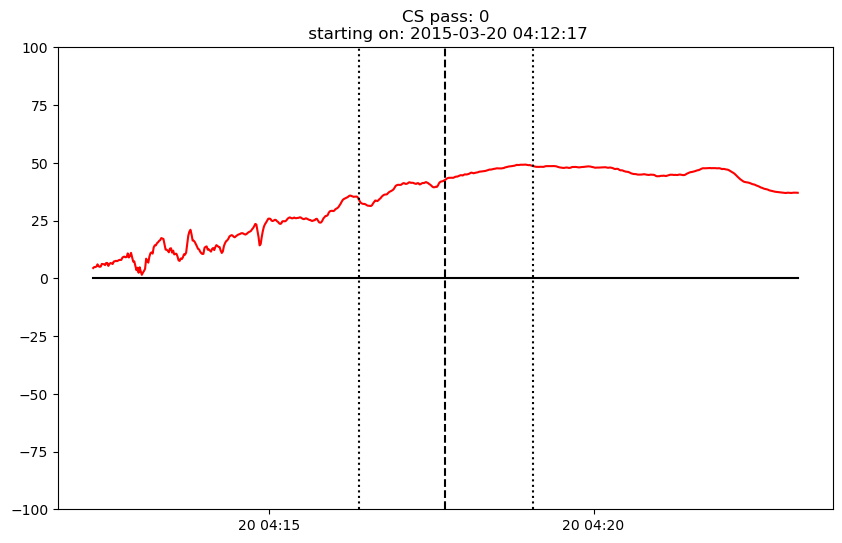

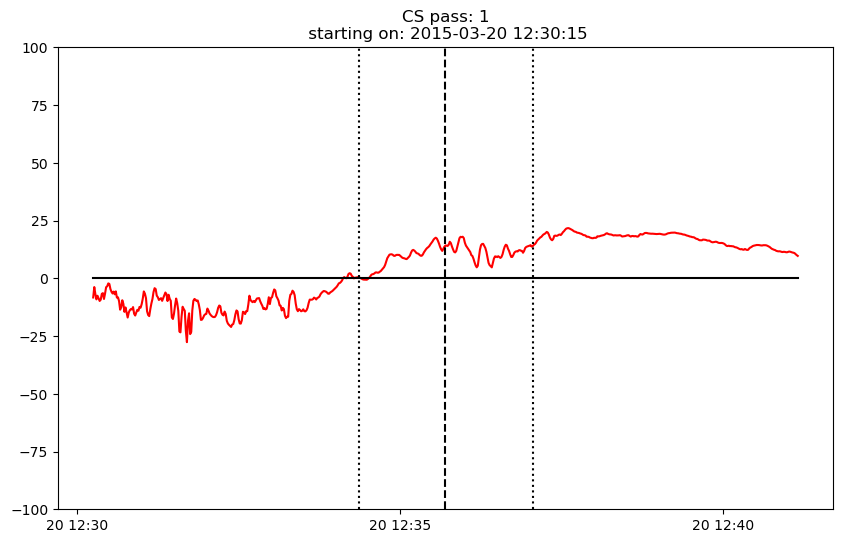

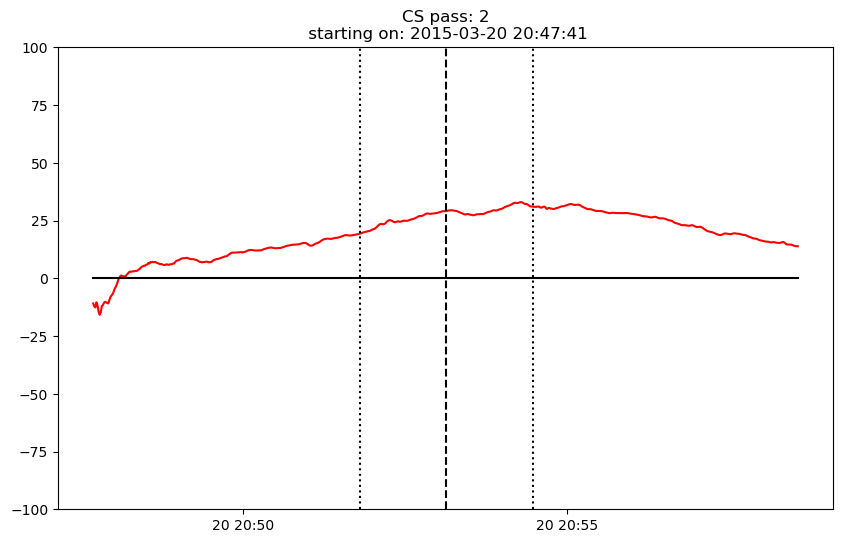

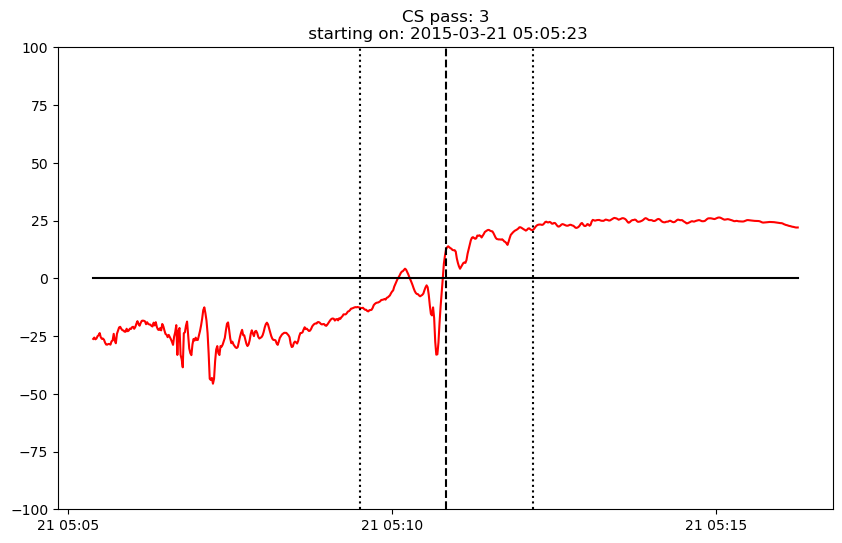

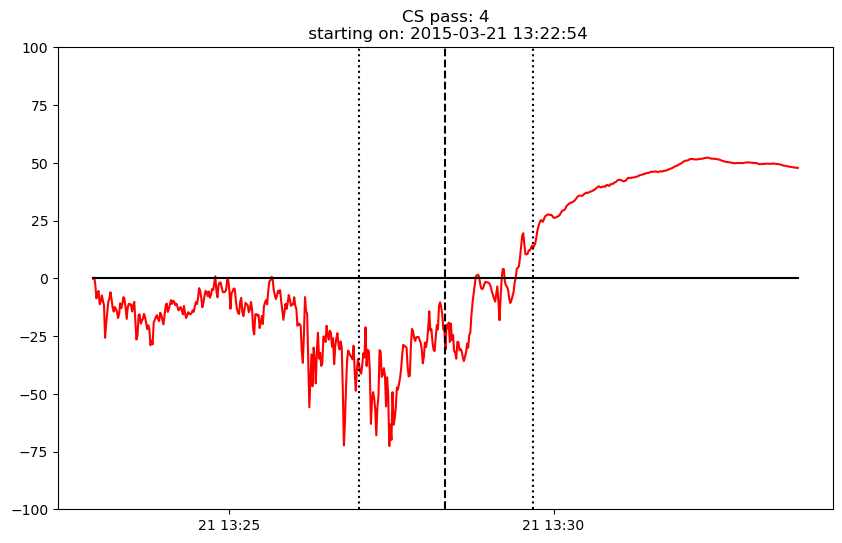

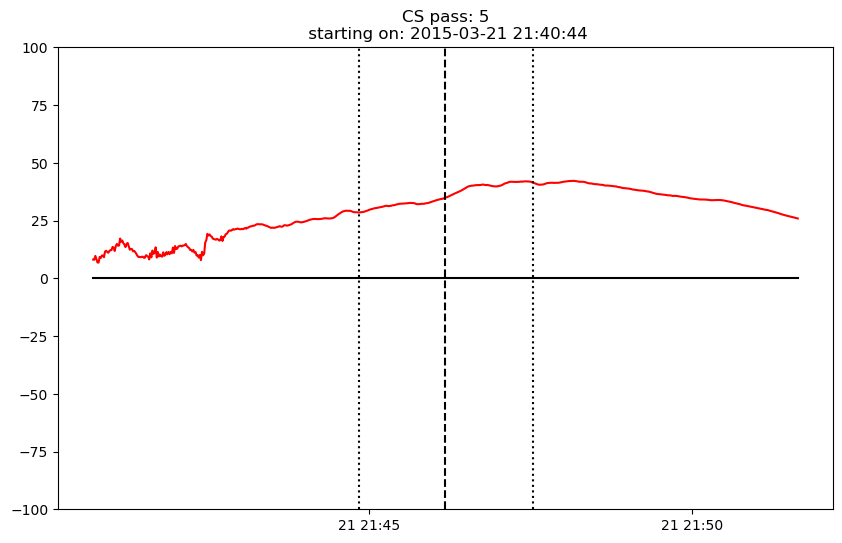

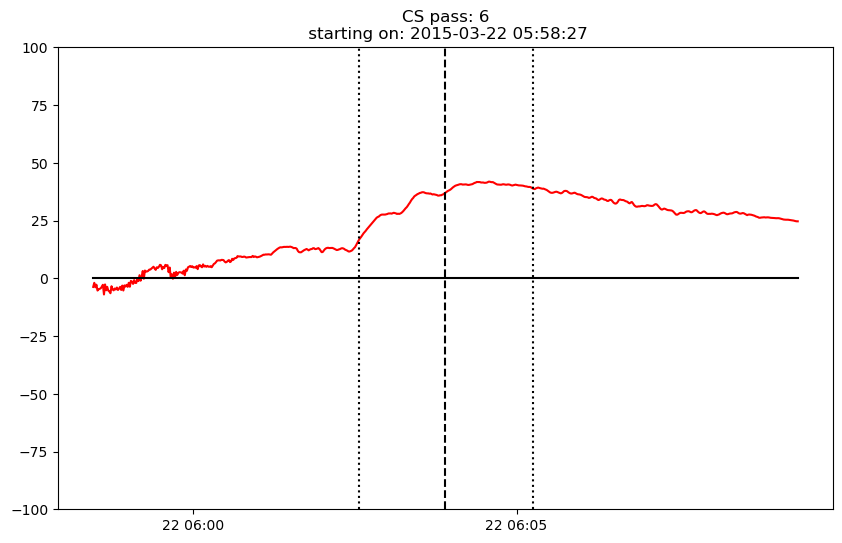

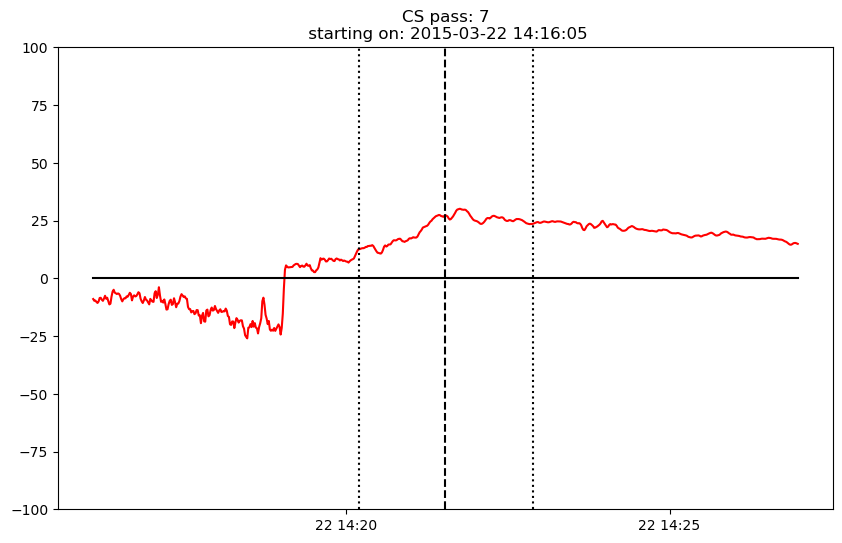

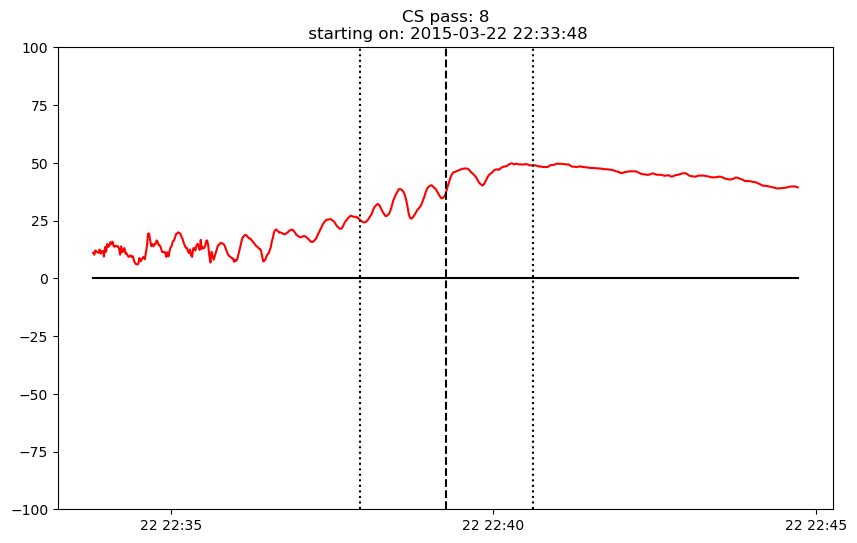

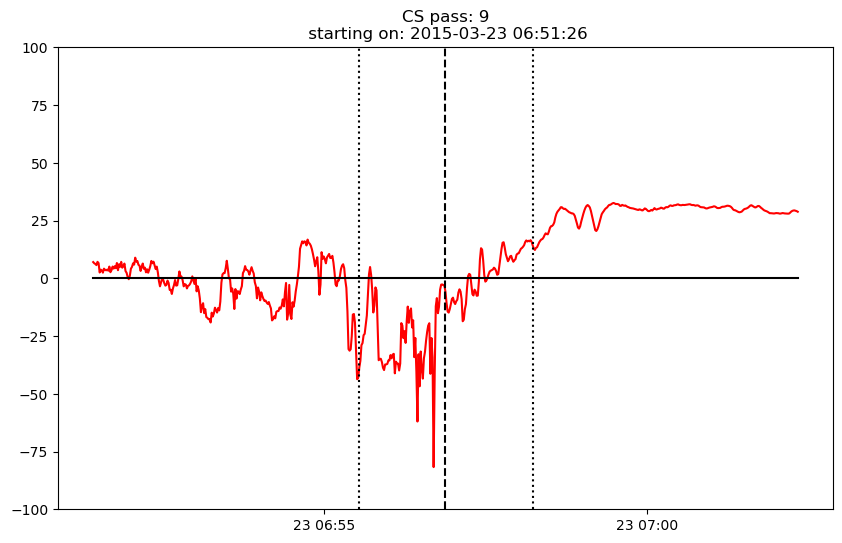

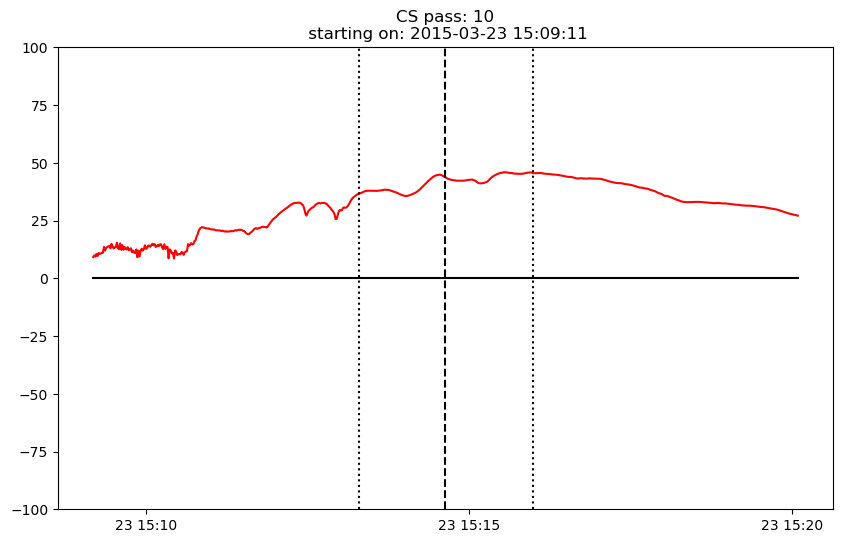

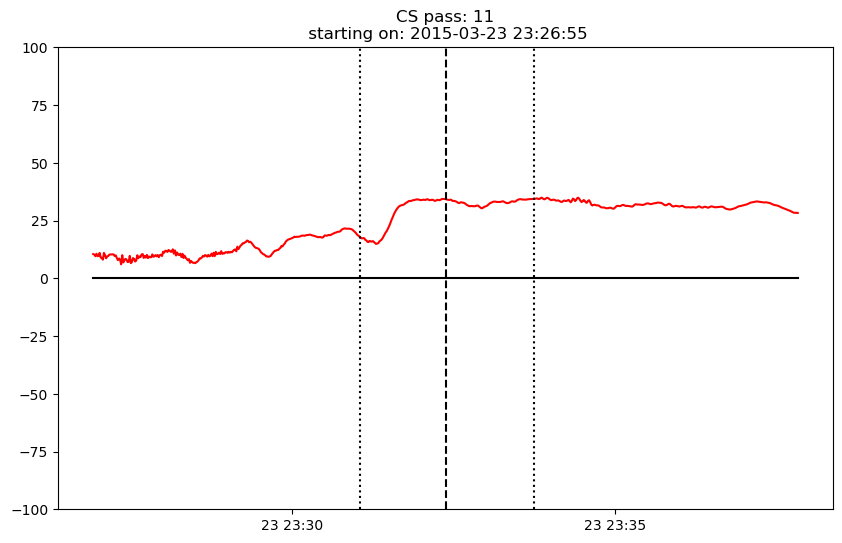

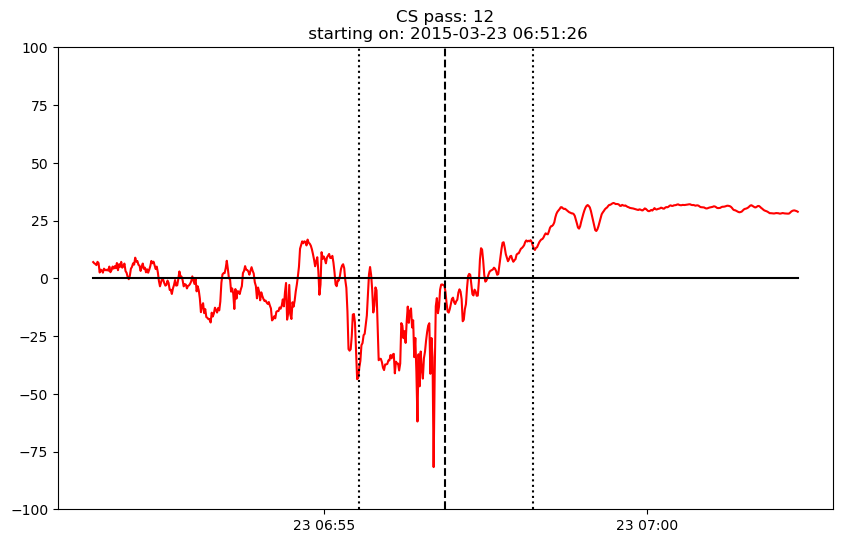

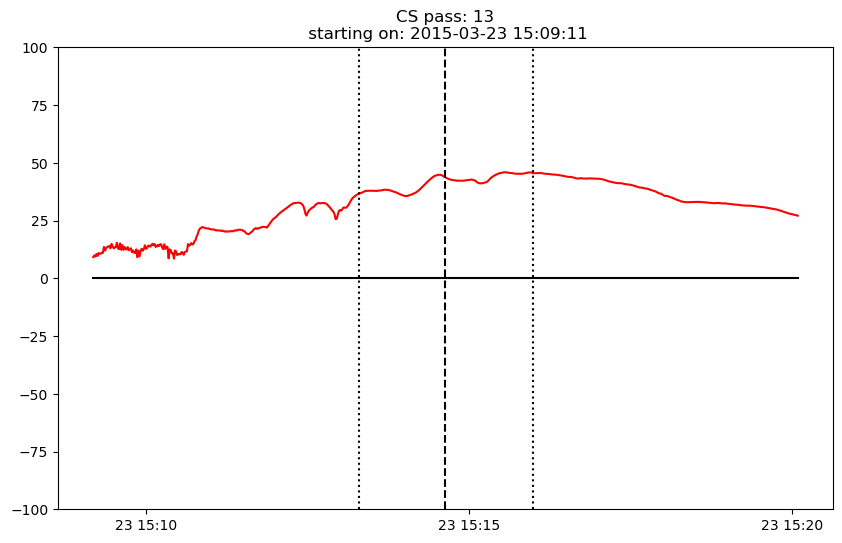

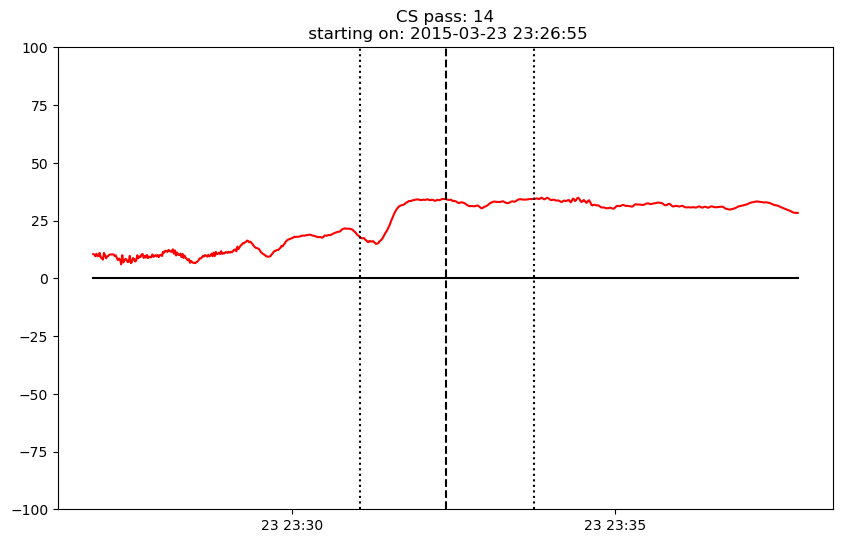

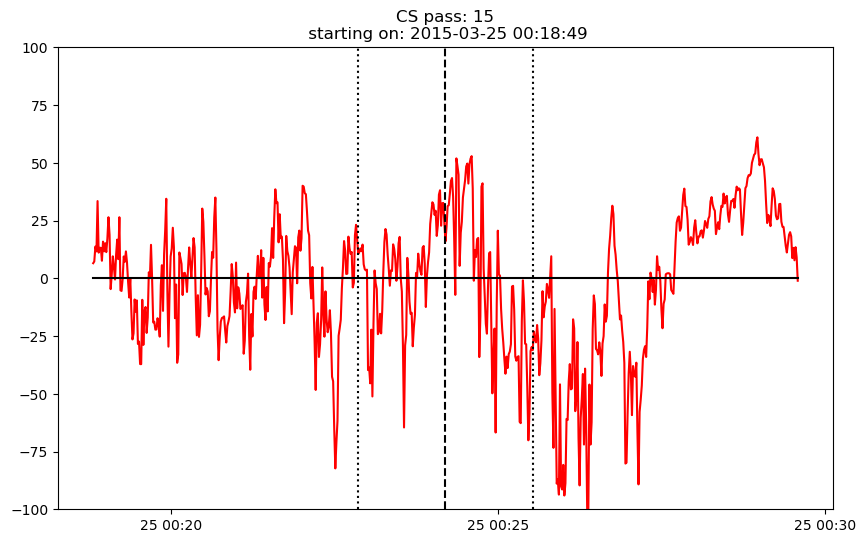

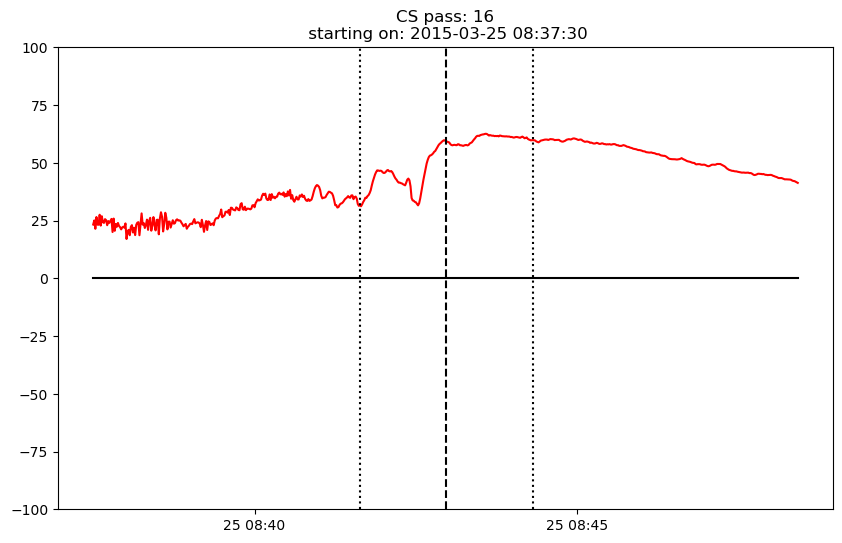

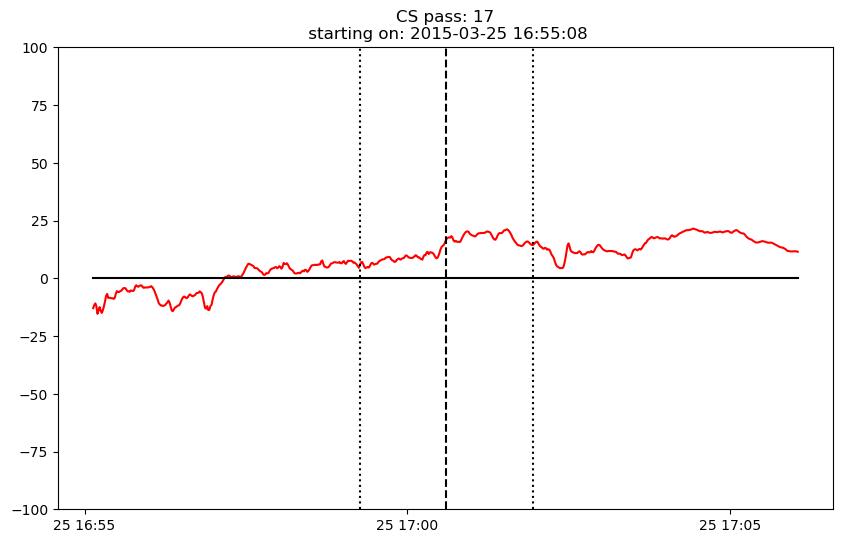

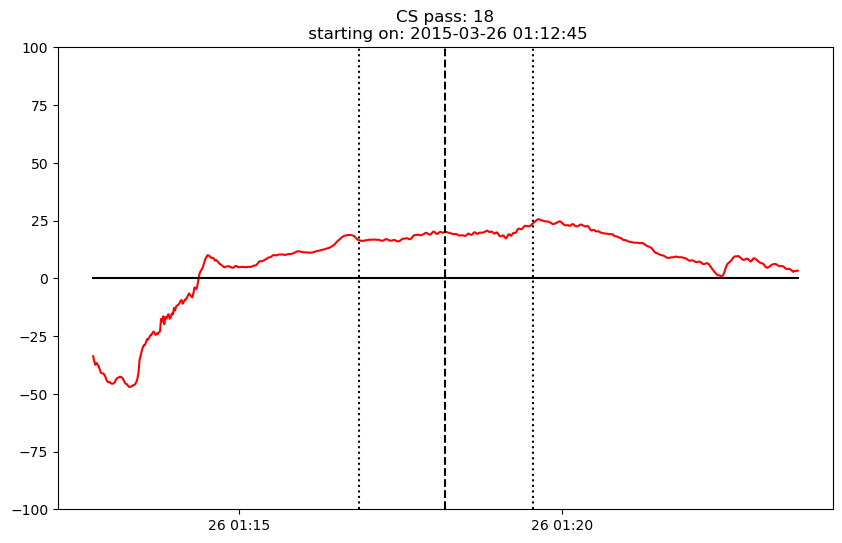

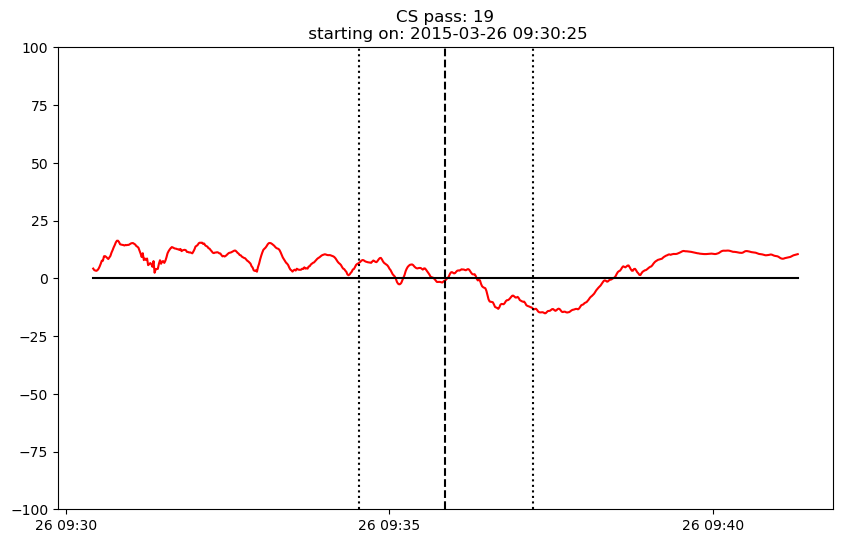

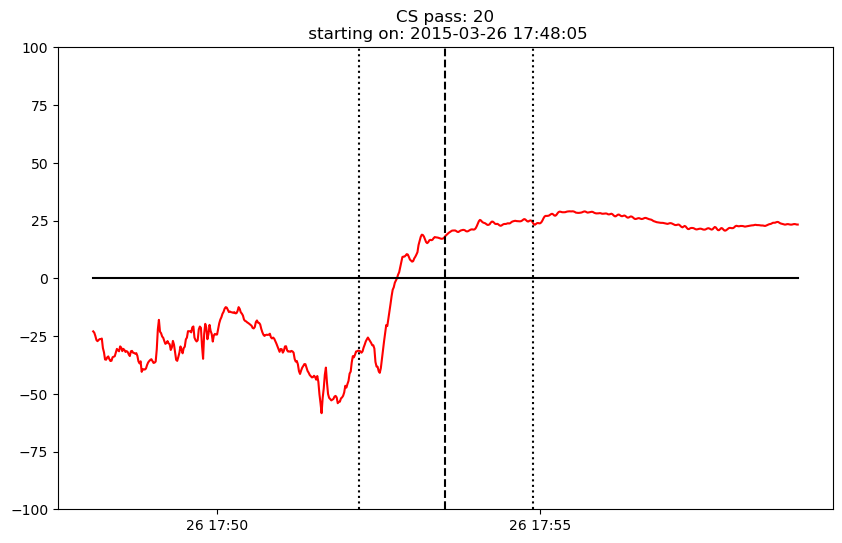

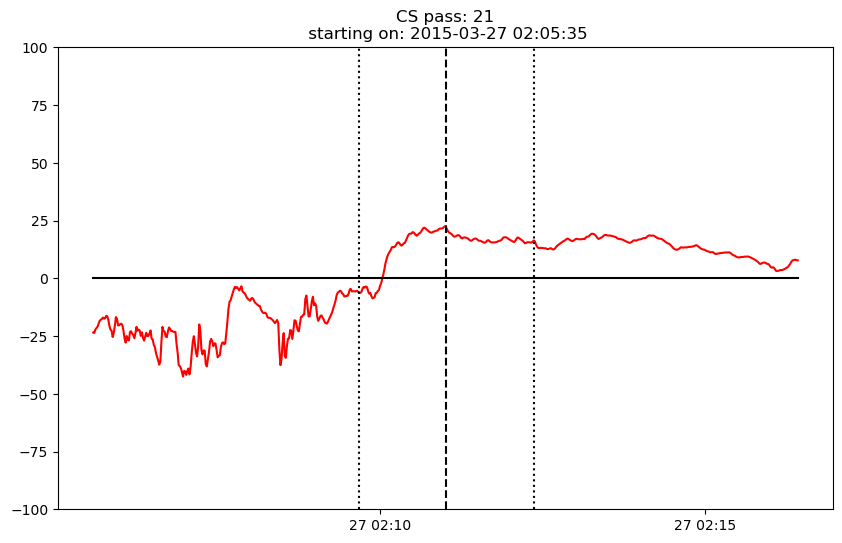

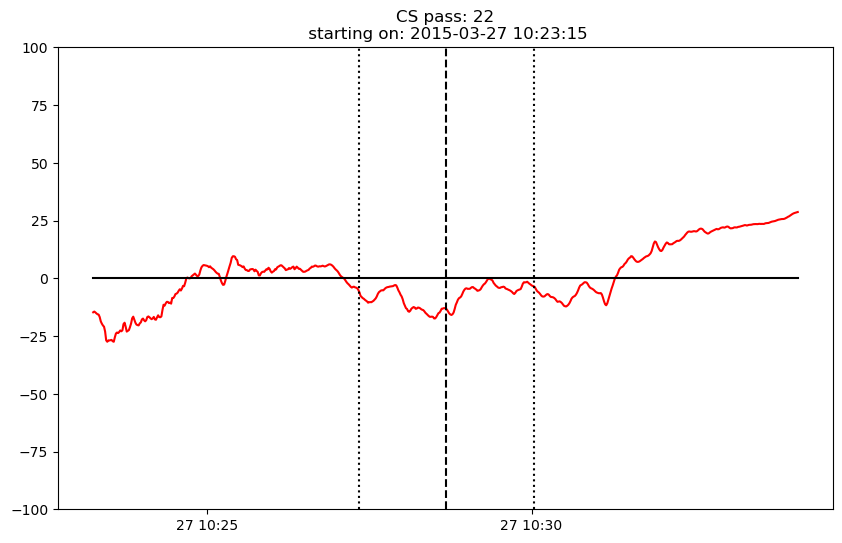

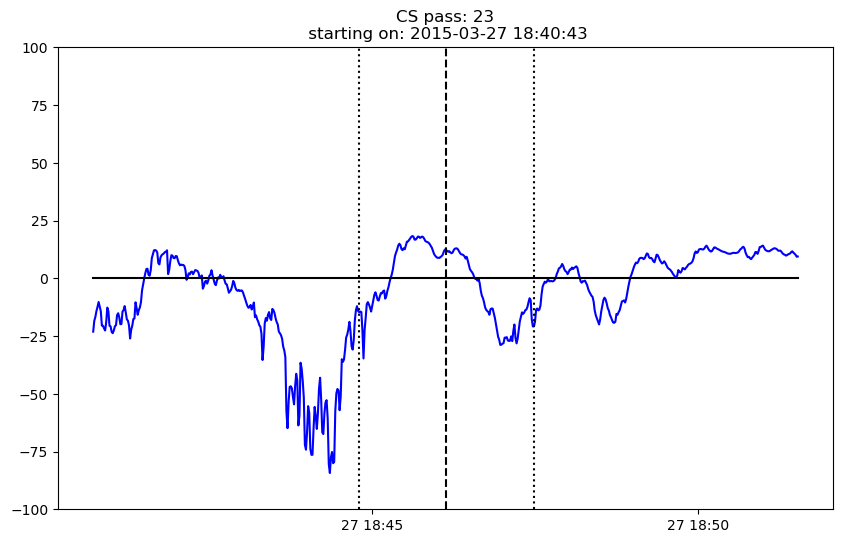

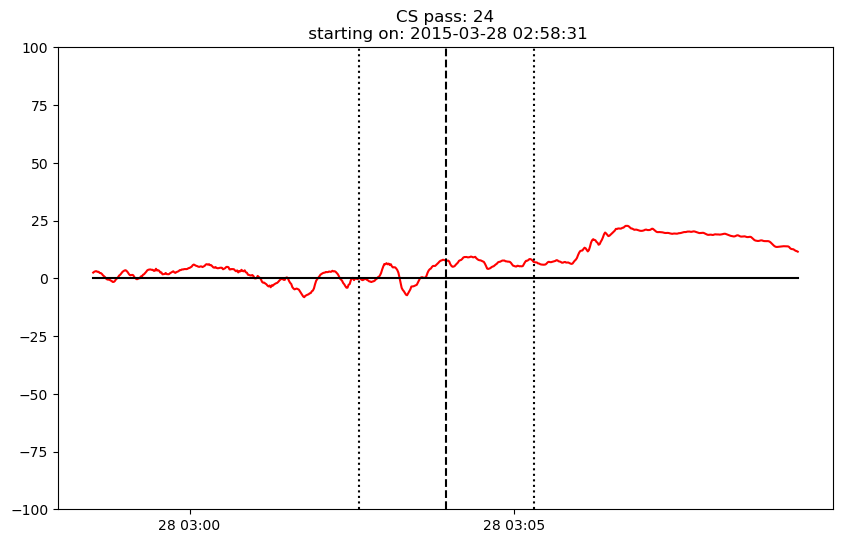

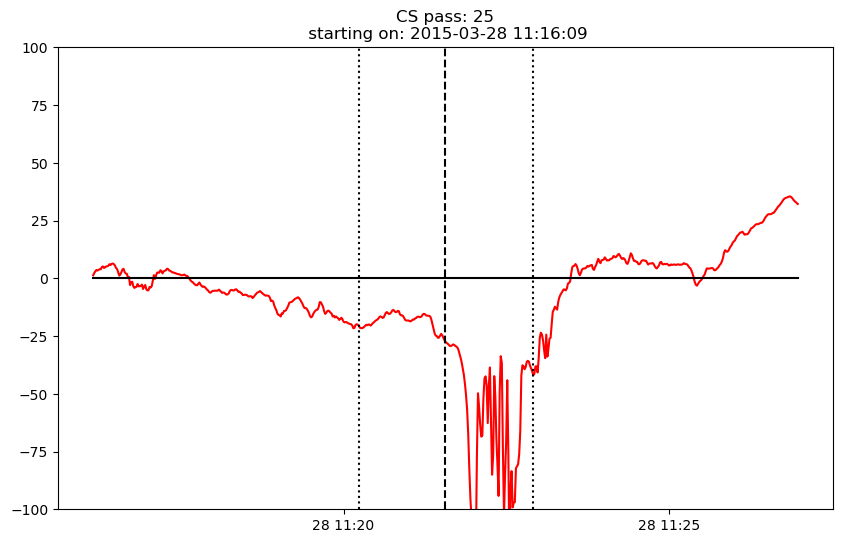

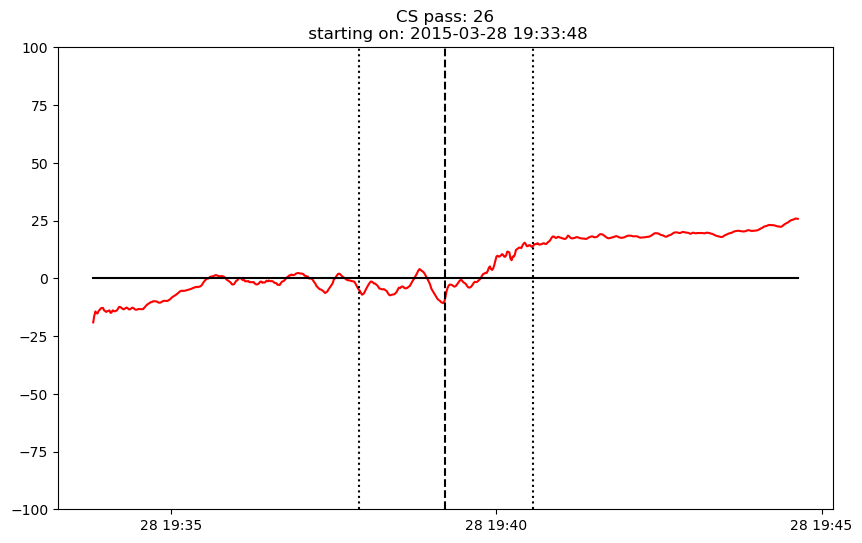

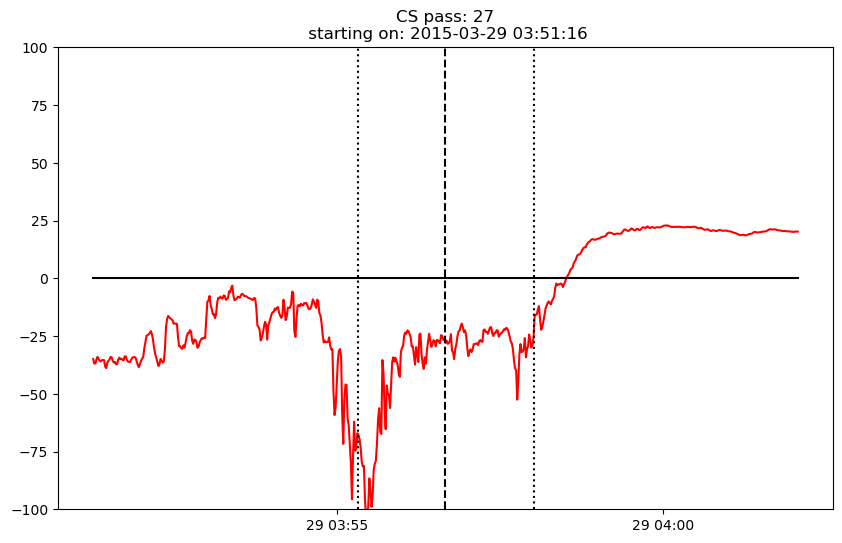

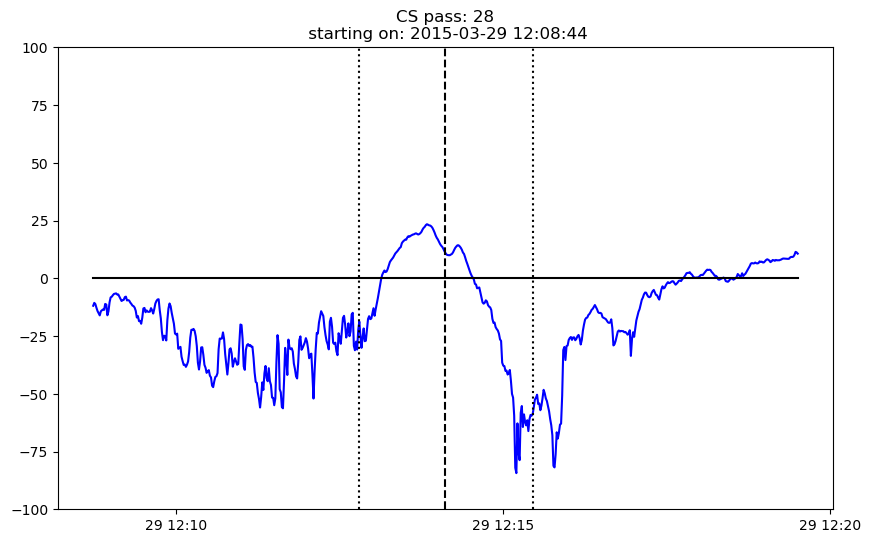

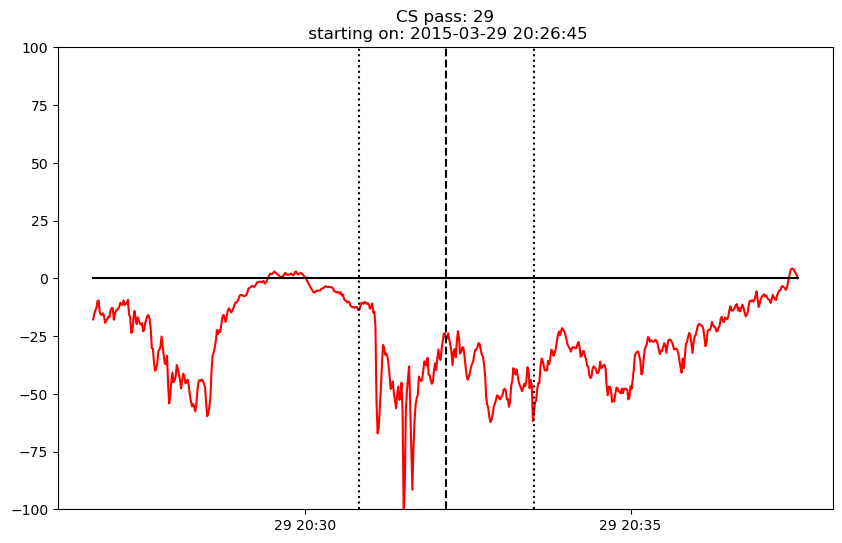

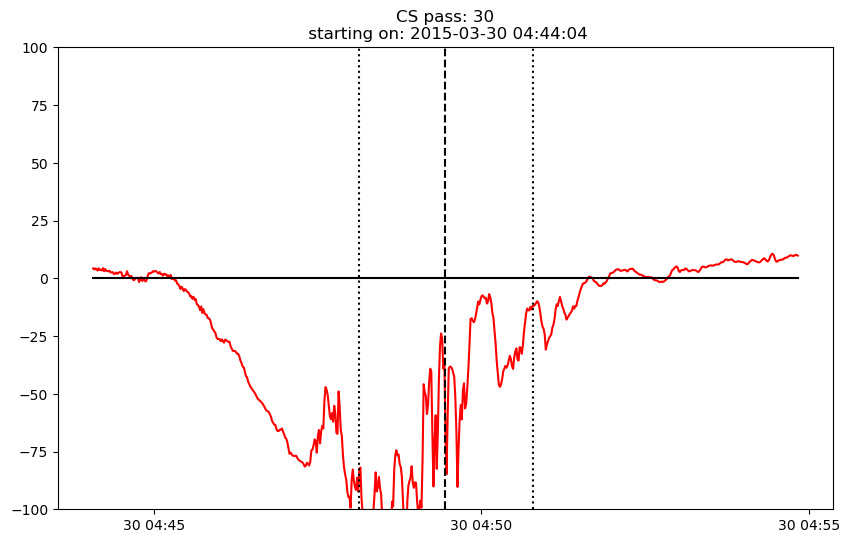

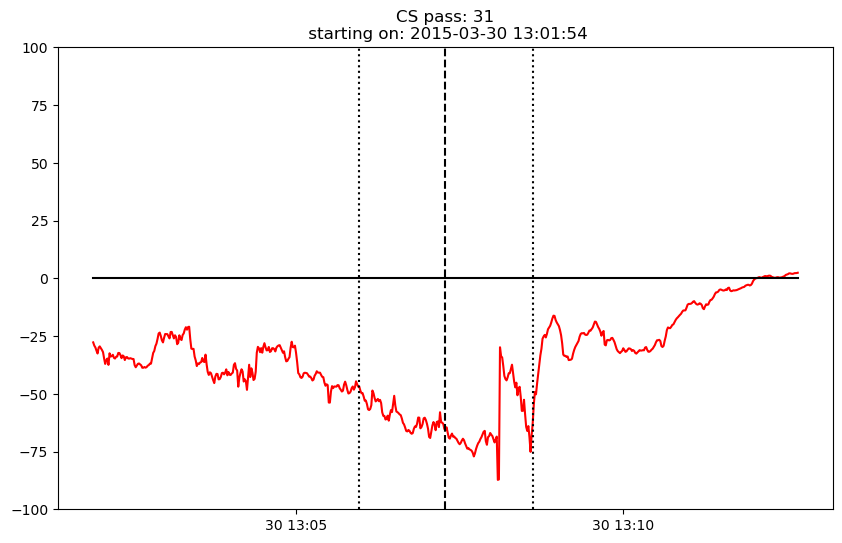

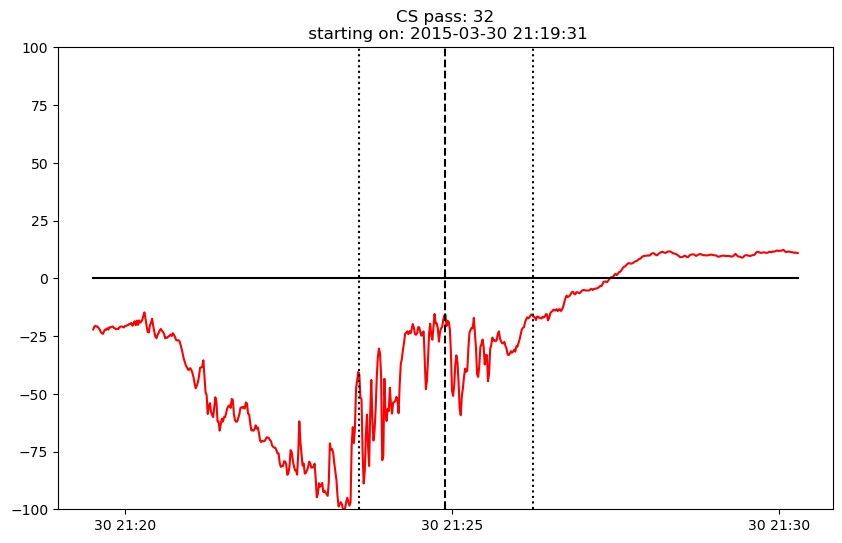

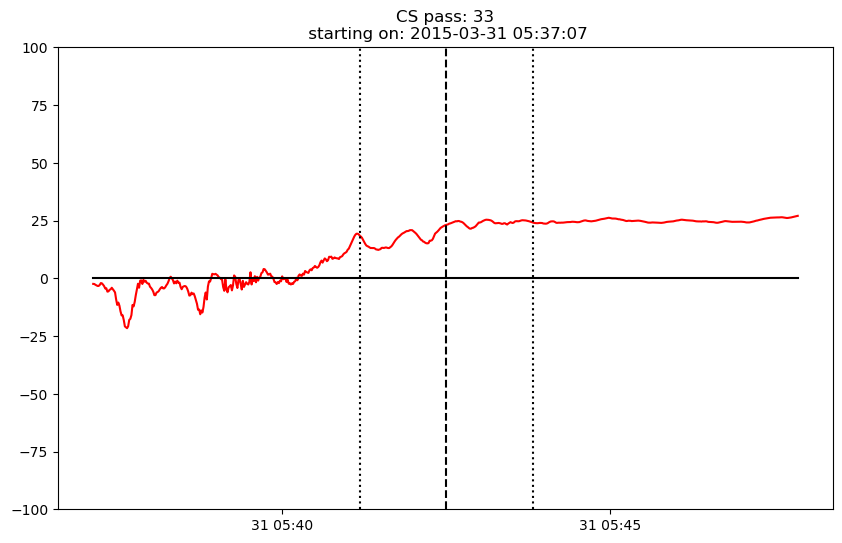

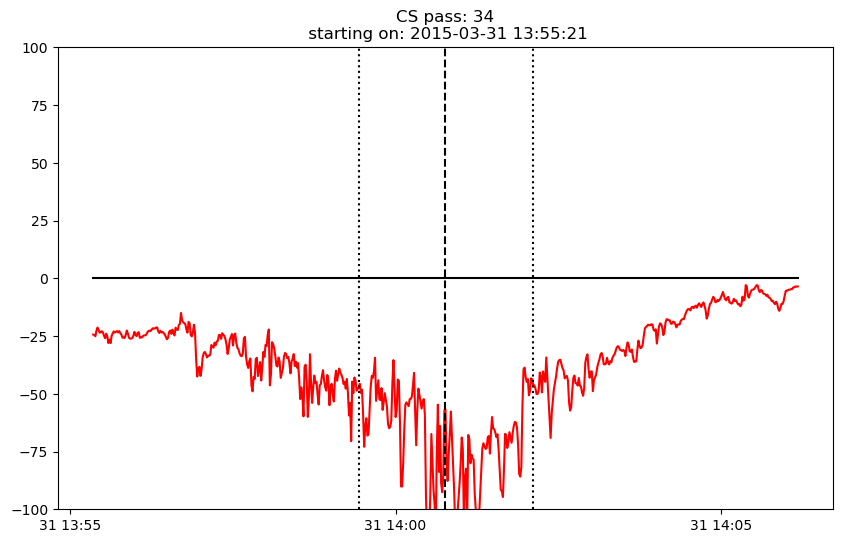

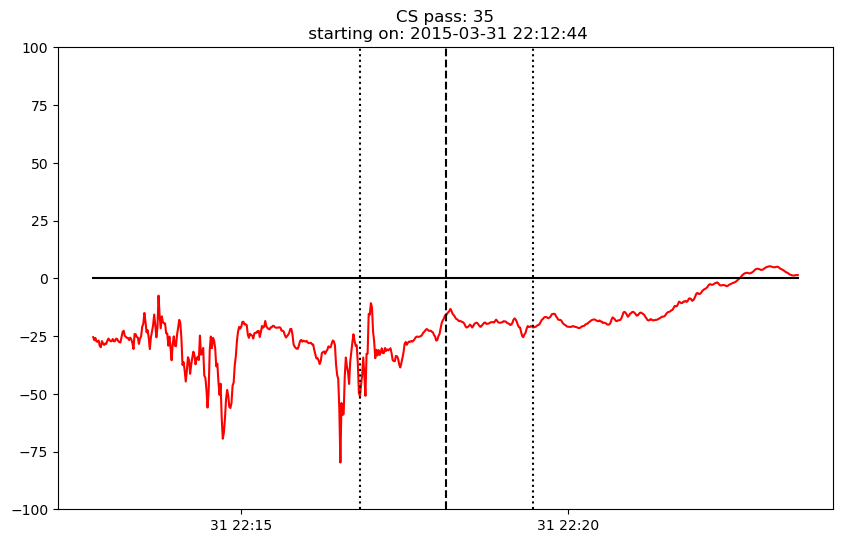

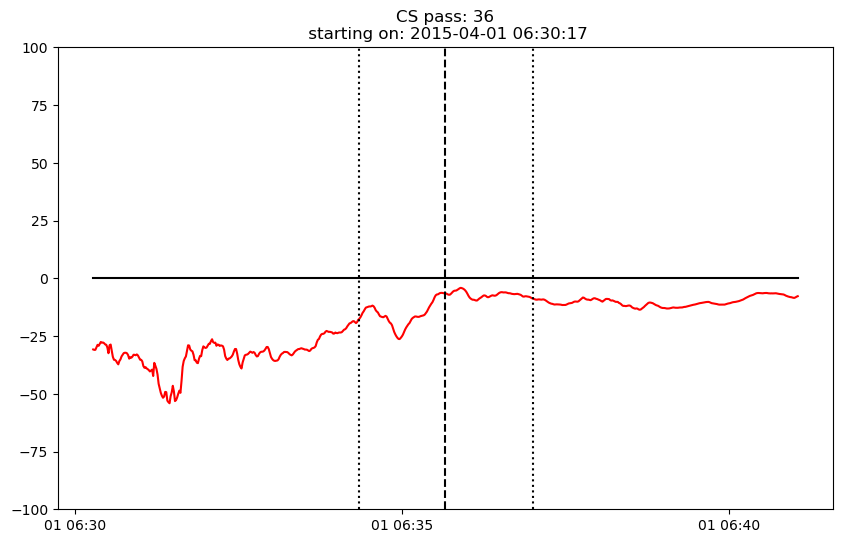

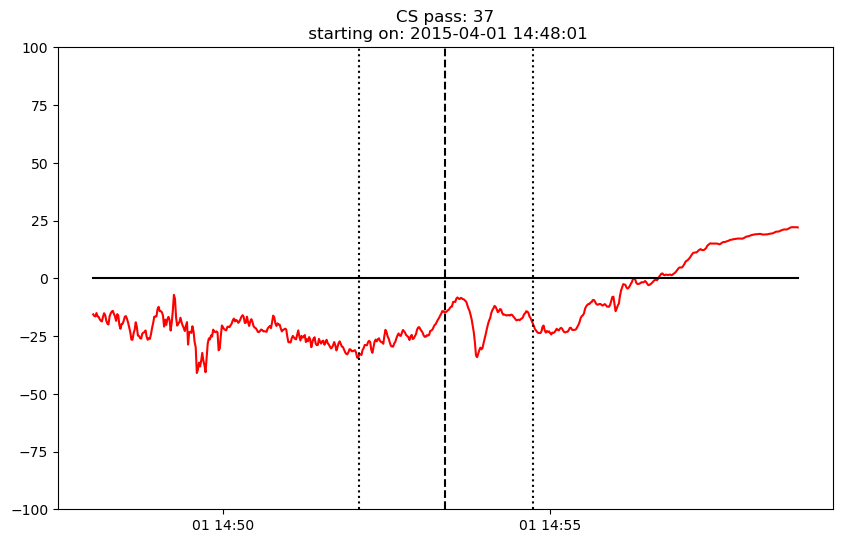

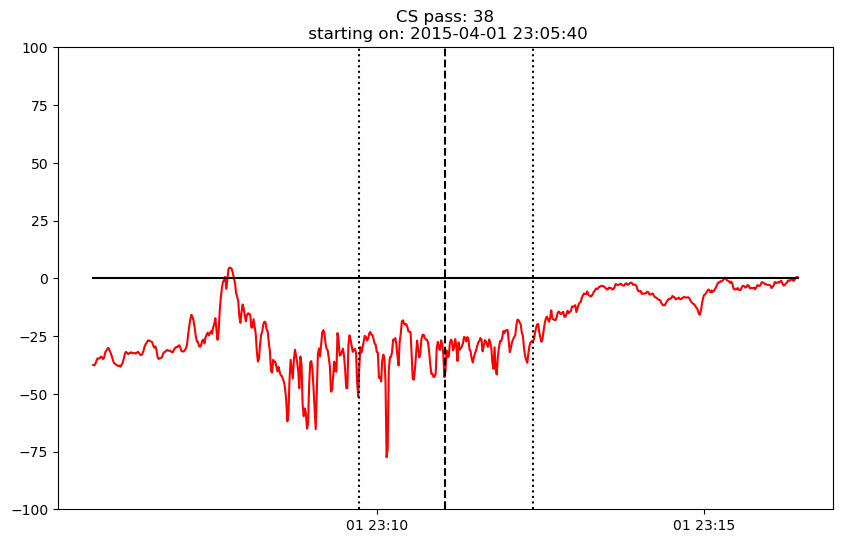

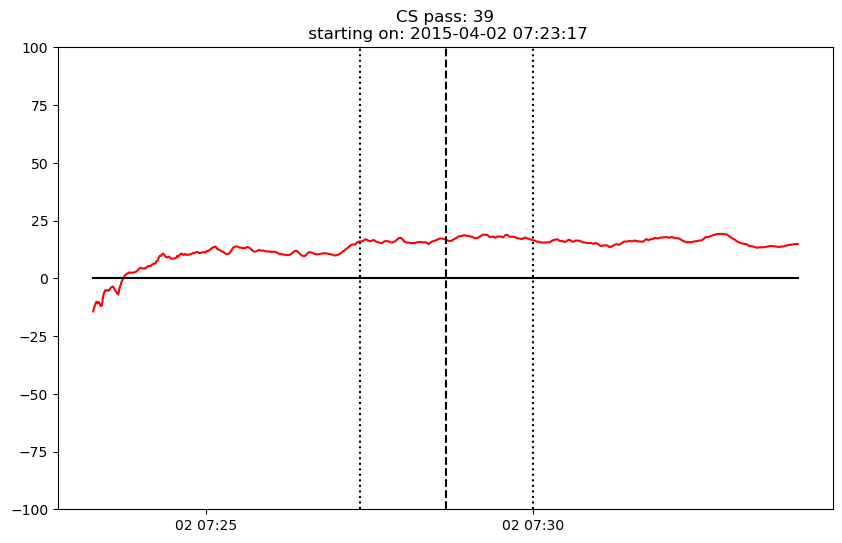

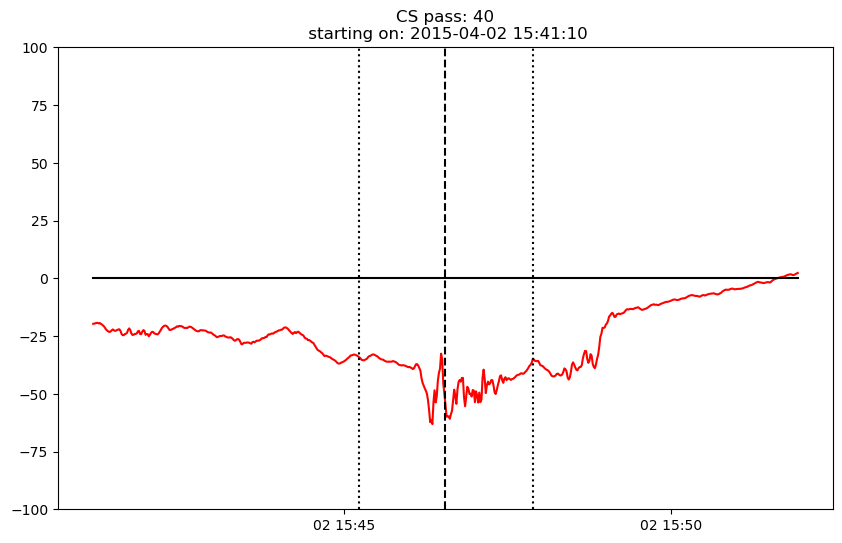

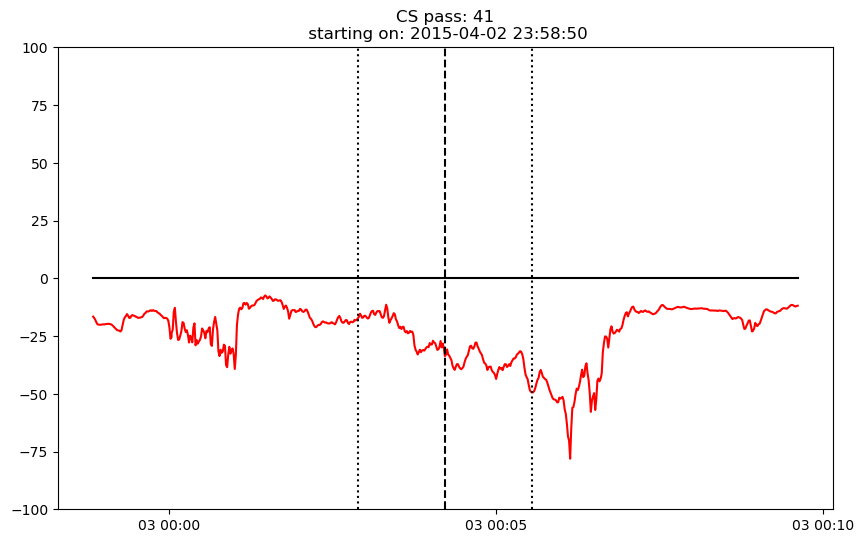

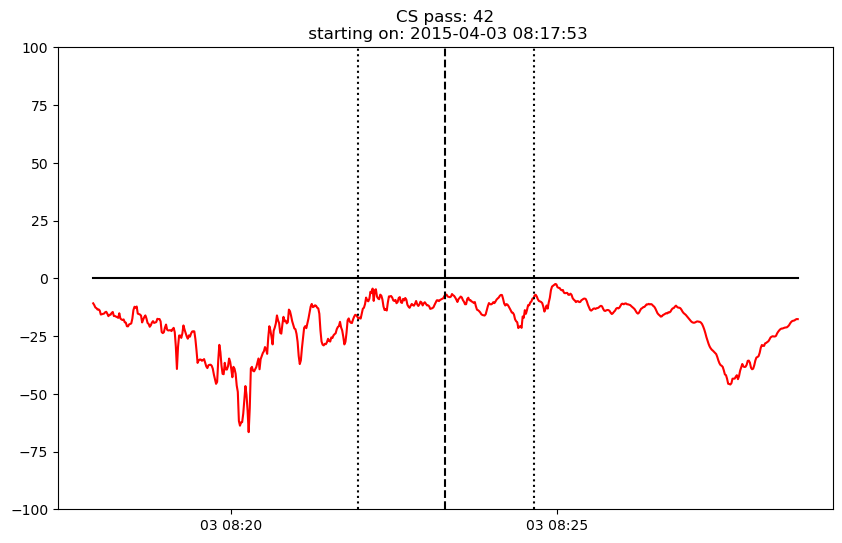

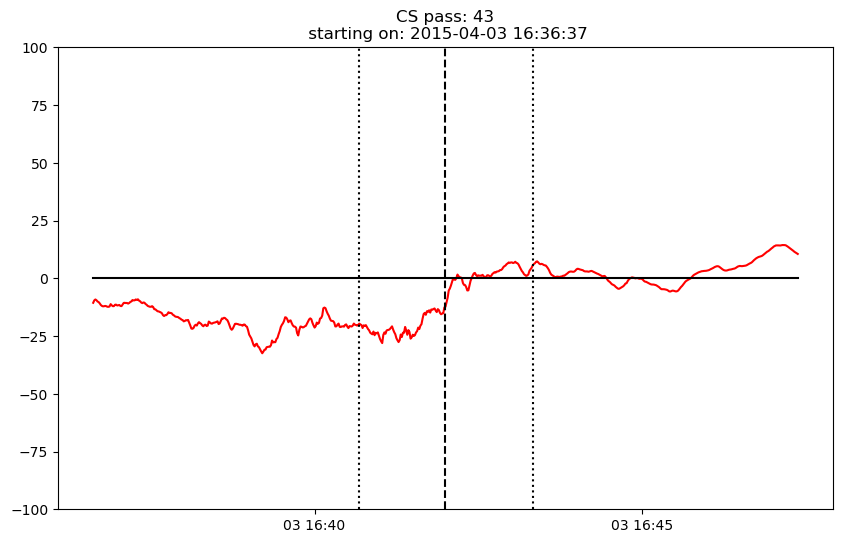

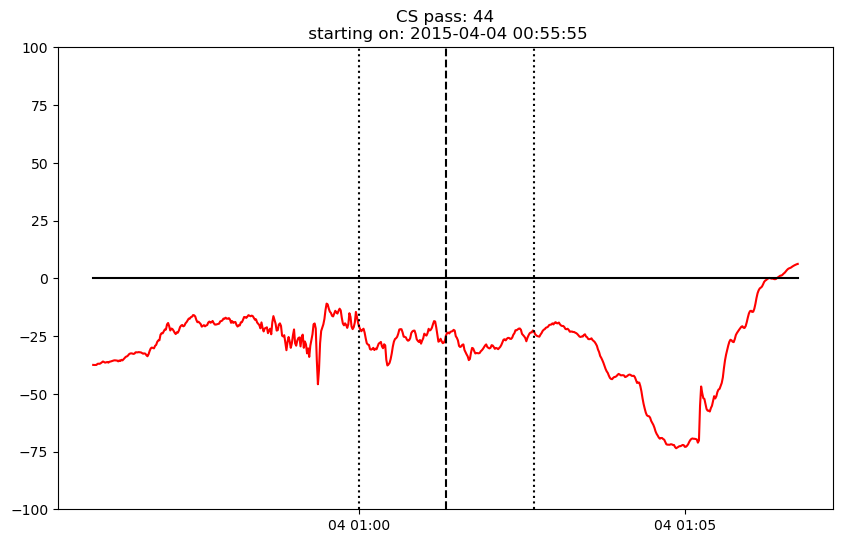

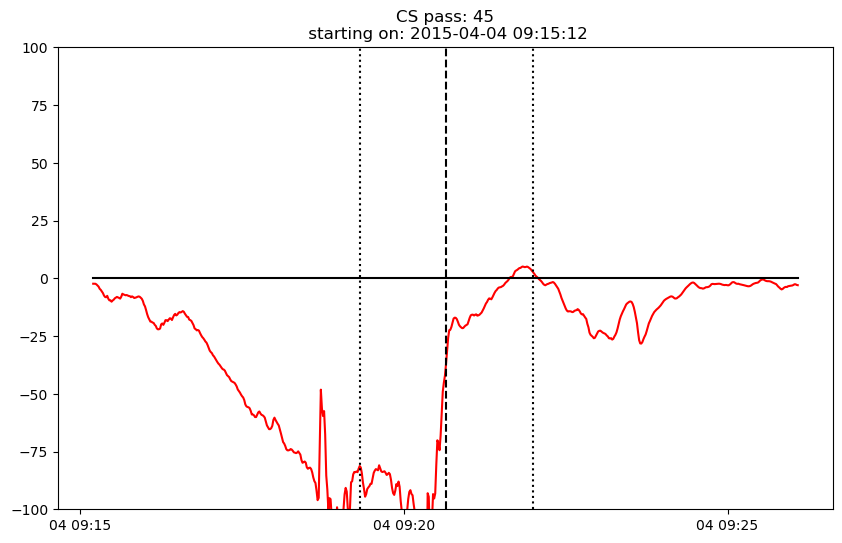

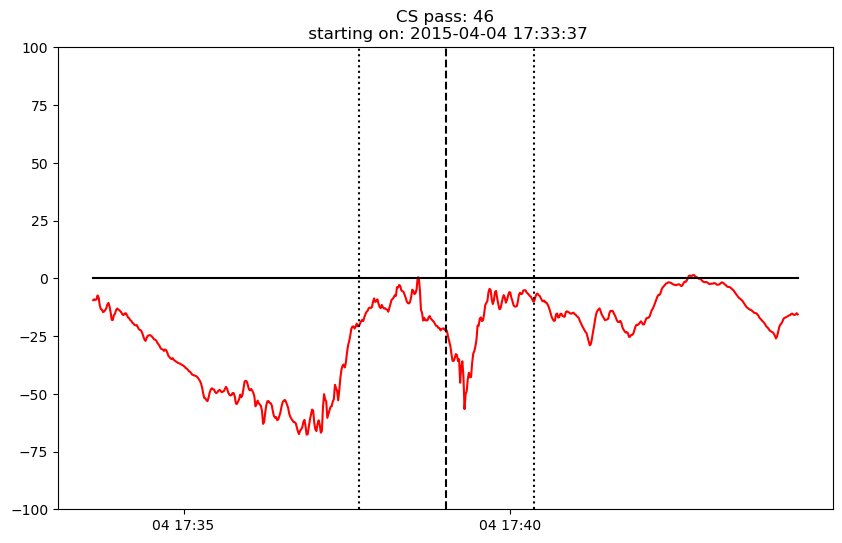

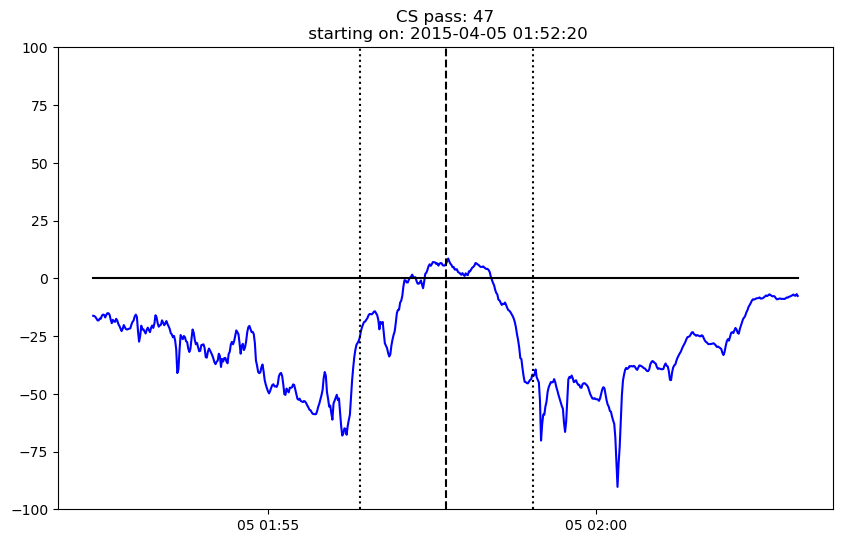

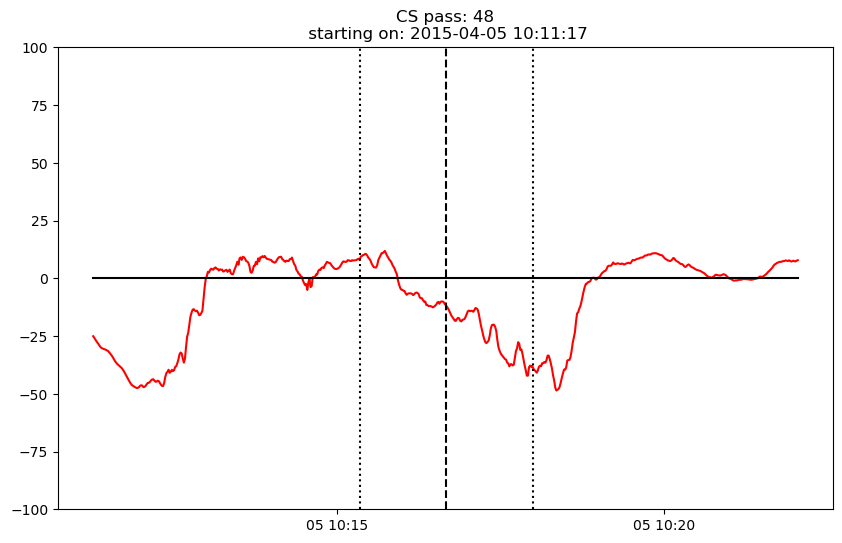

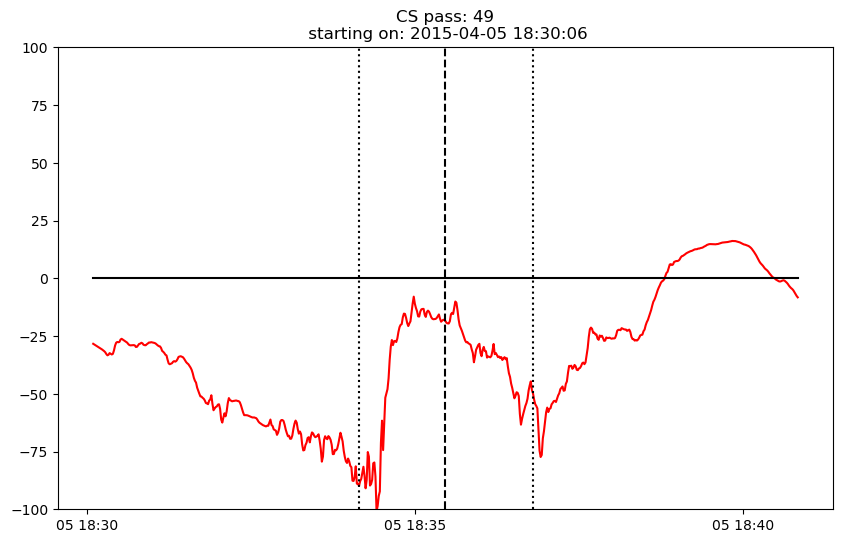

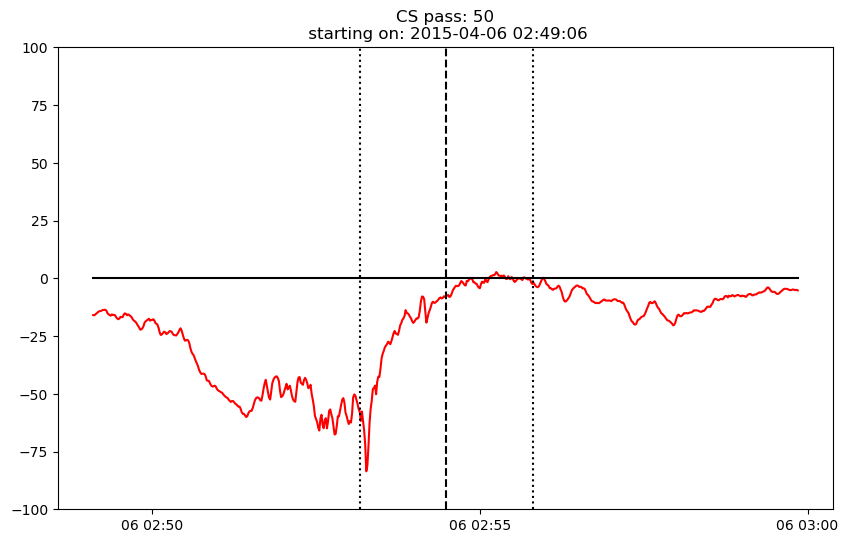

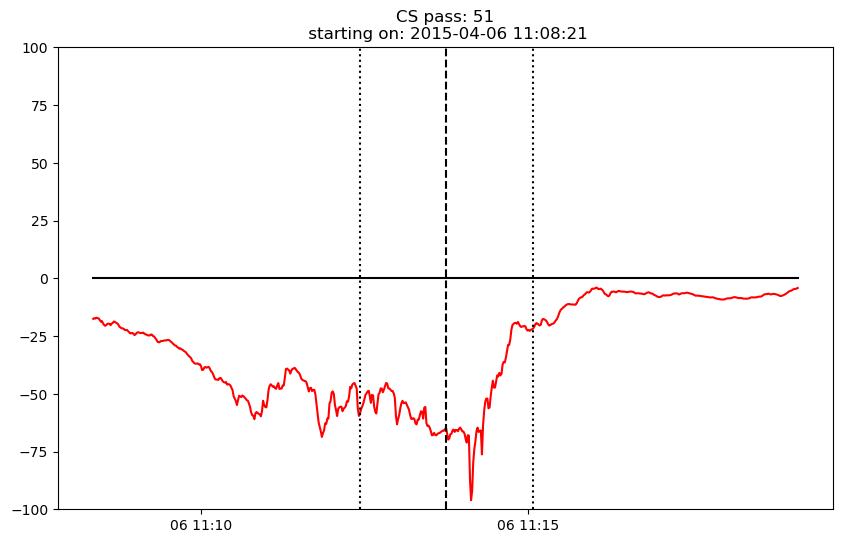

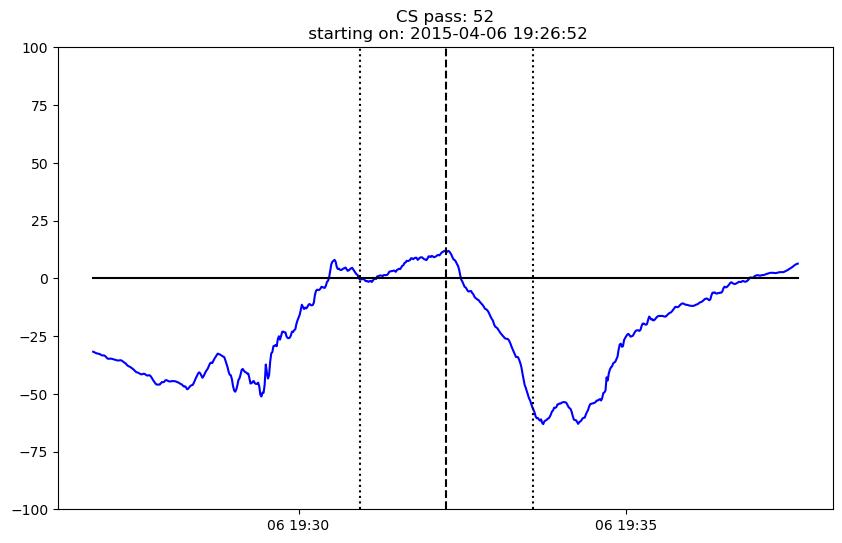

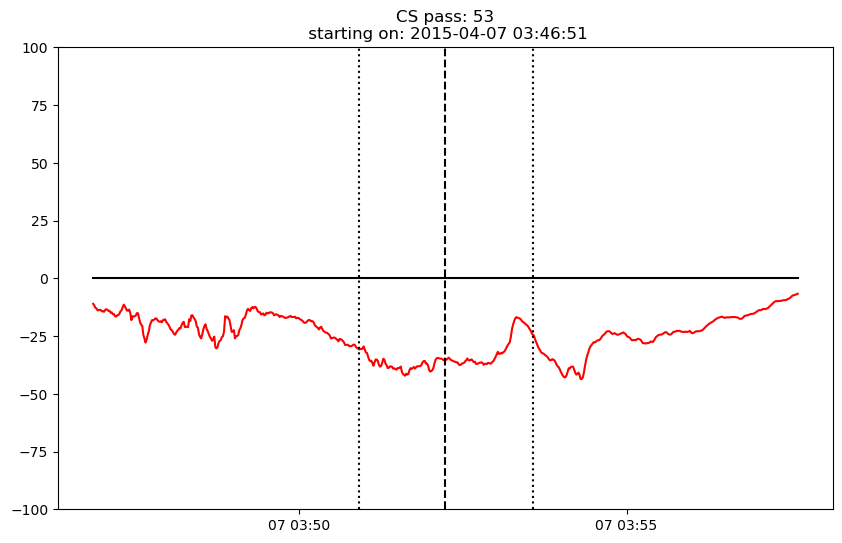

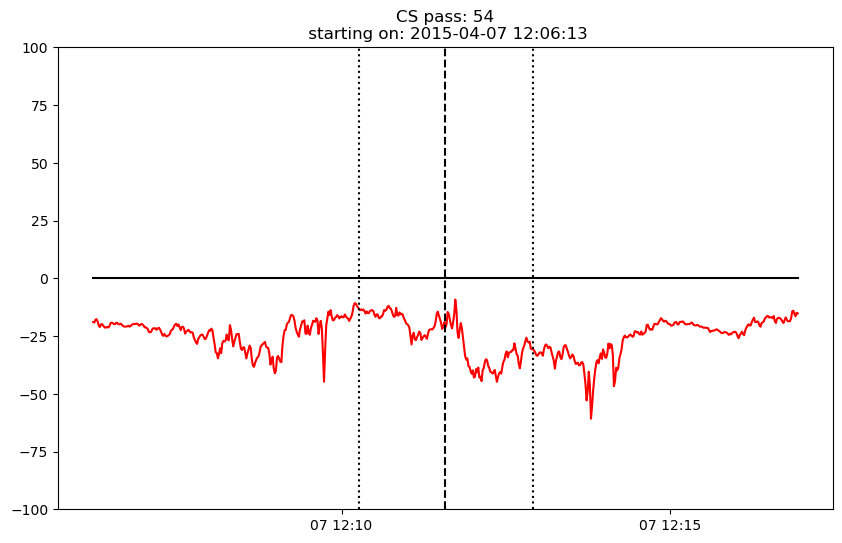

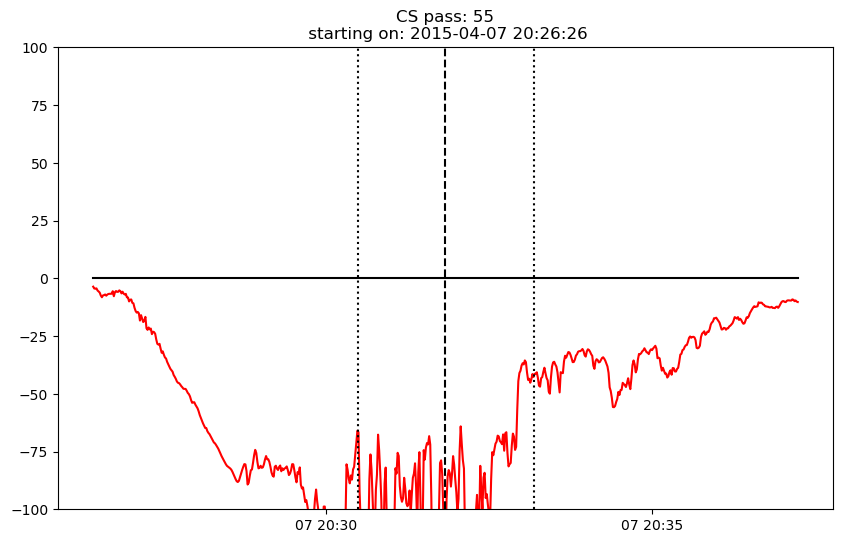

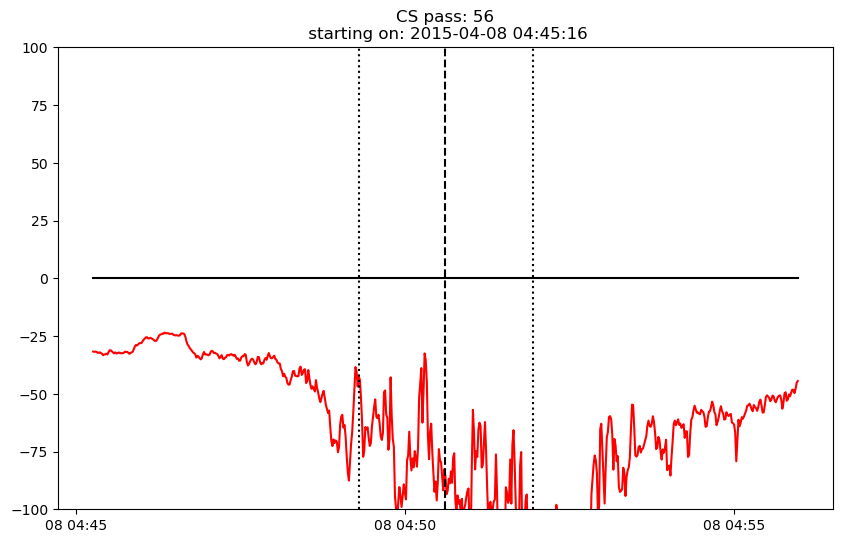

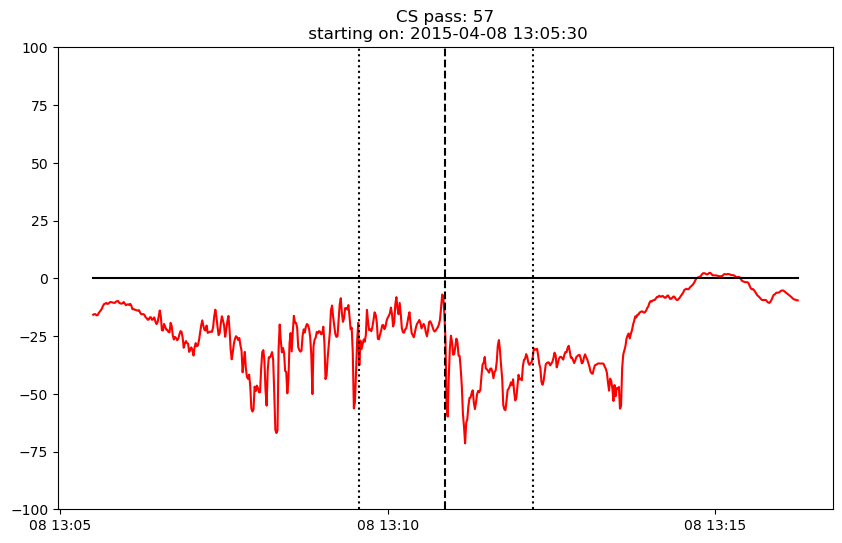

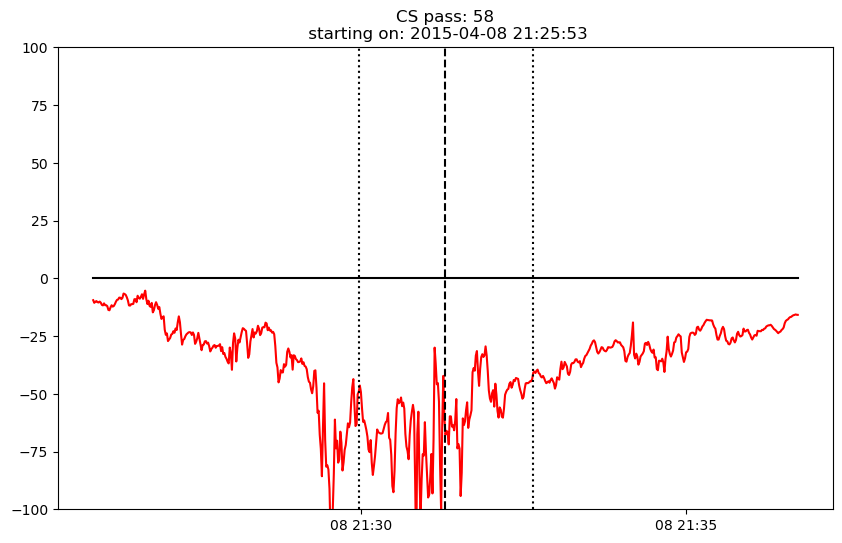

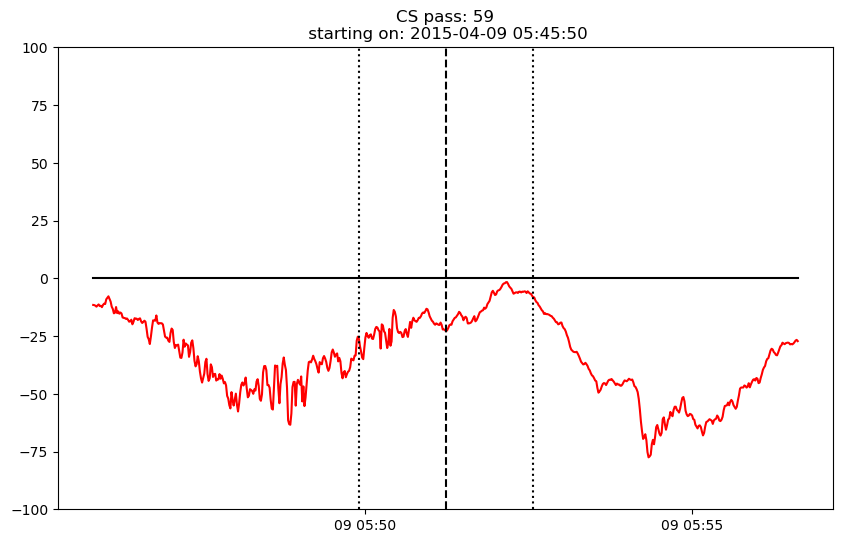

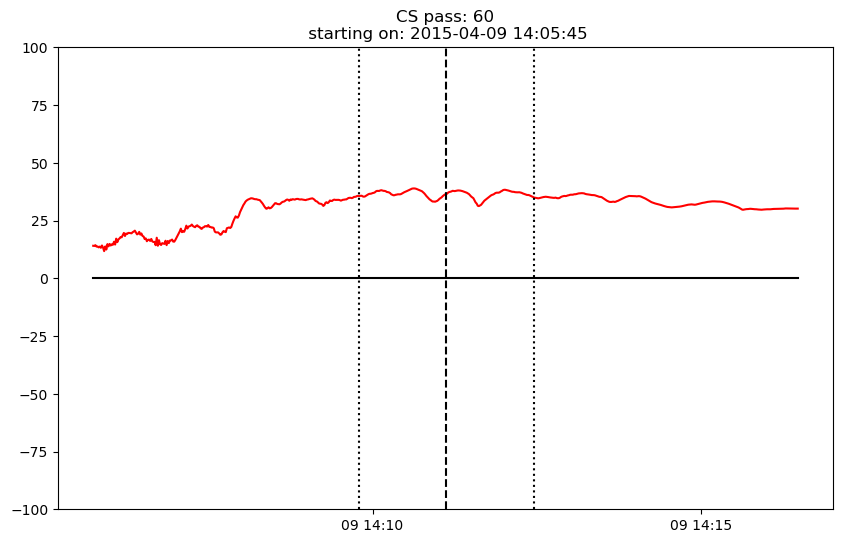

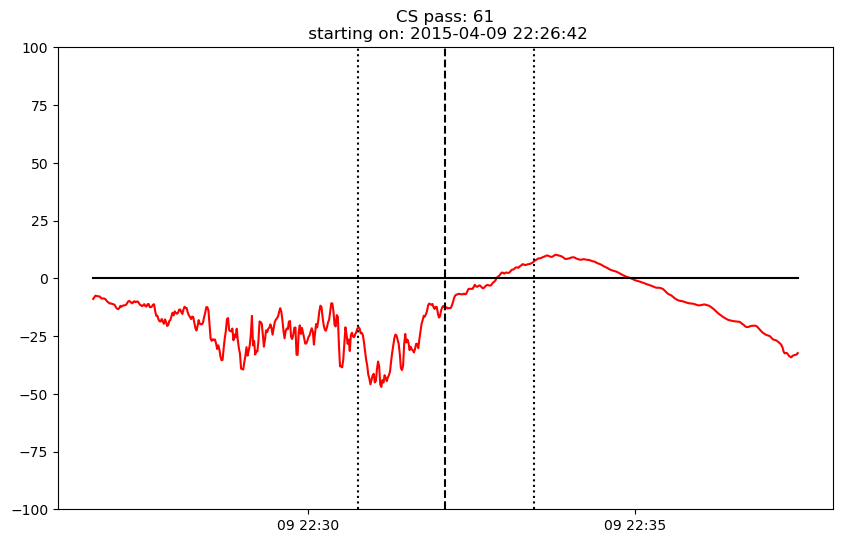

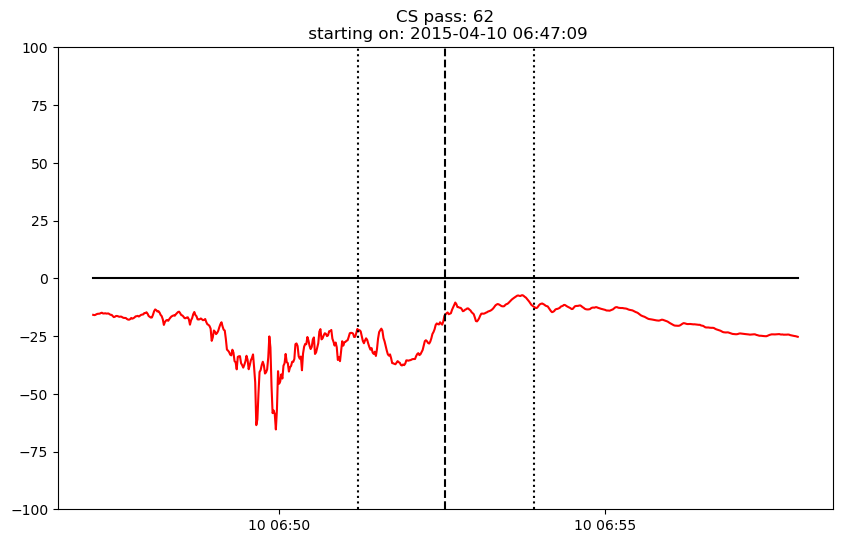

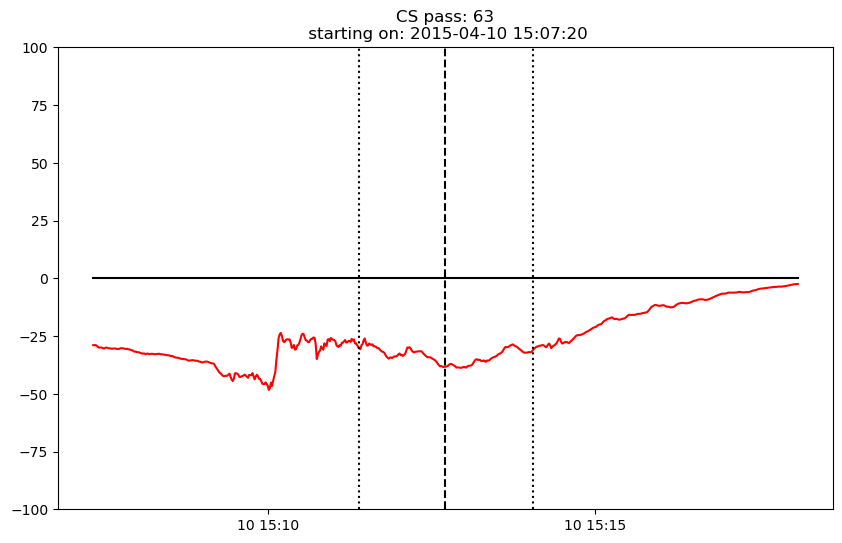

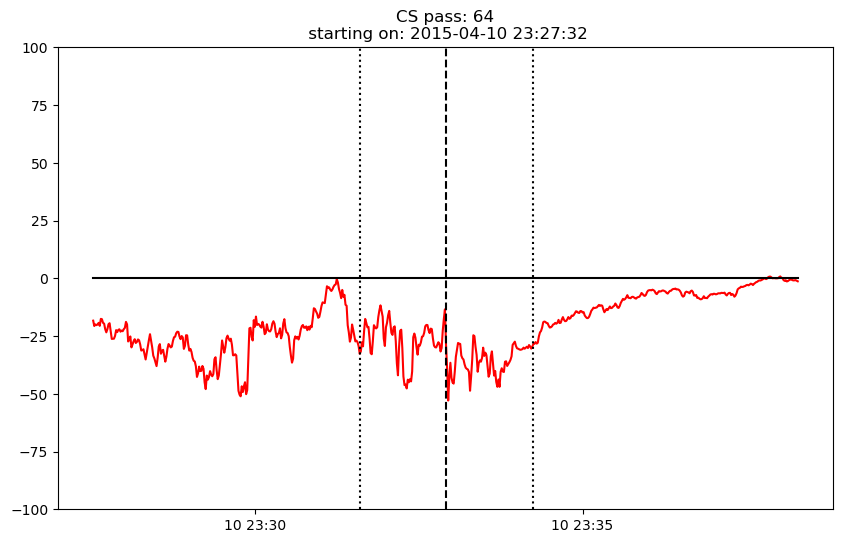

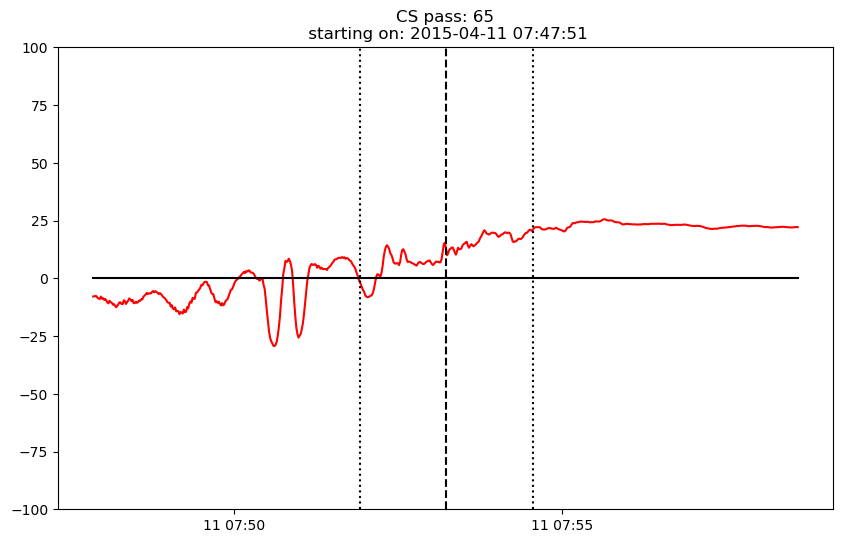

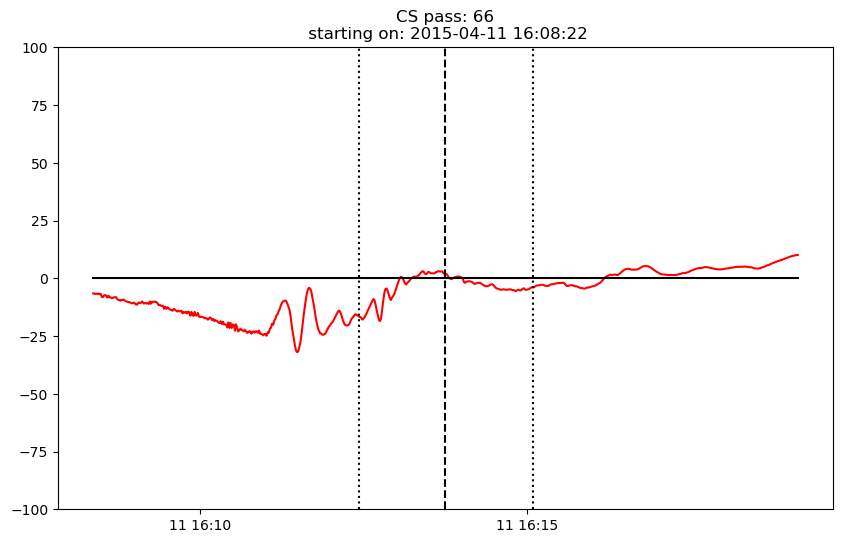

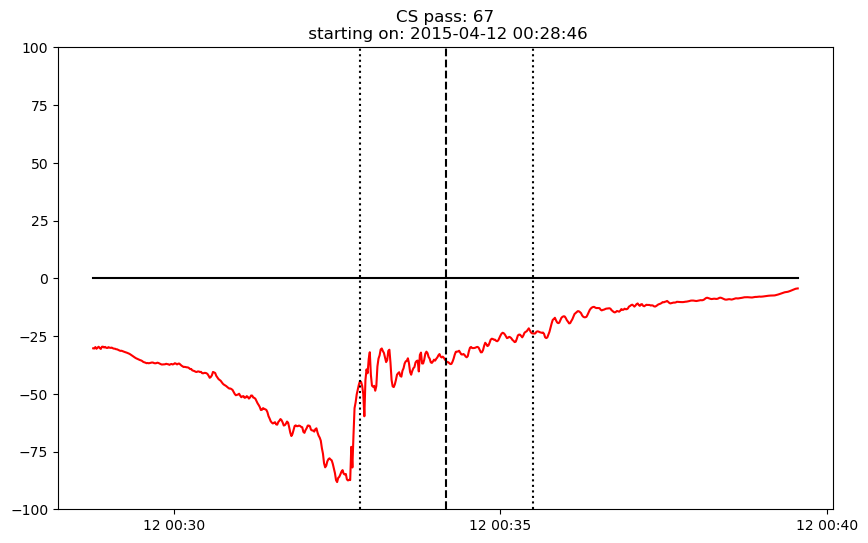

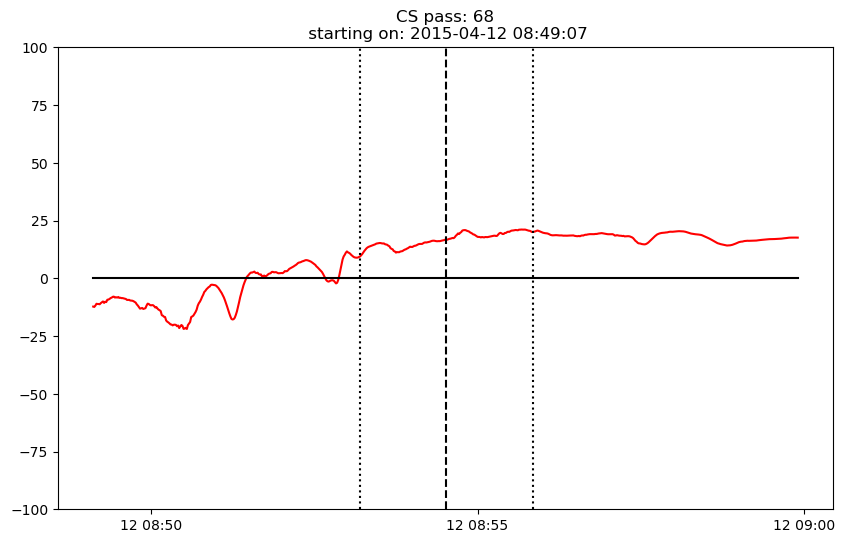

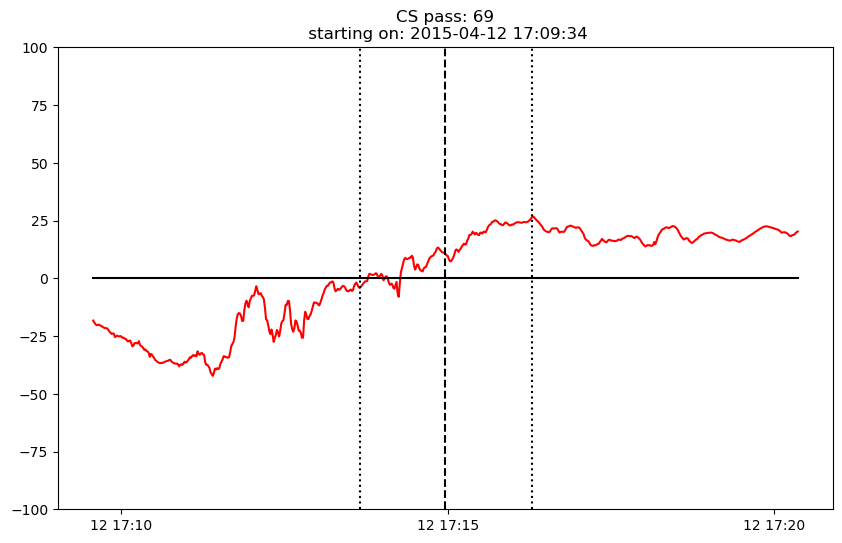

In [9]:
# Show all the cs passes
#plot_Bz_minus_Bzdip(df_cs)

# Determine the centered DR-type events (requires the 'Bx' fitting mode such that the cs center is the middle index of each cs pass)
DR_passes = extract_DR_passes(df_cs,max_DR_width=0.2)

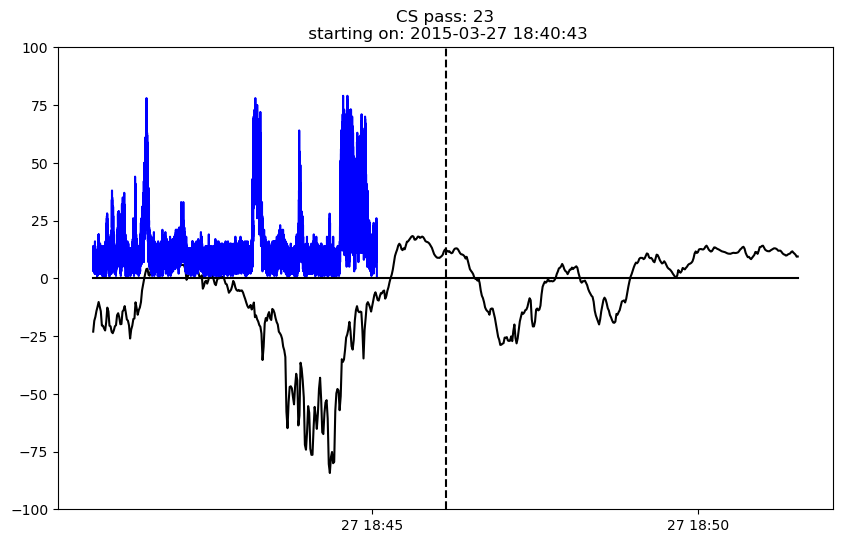

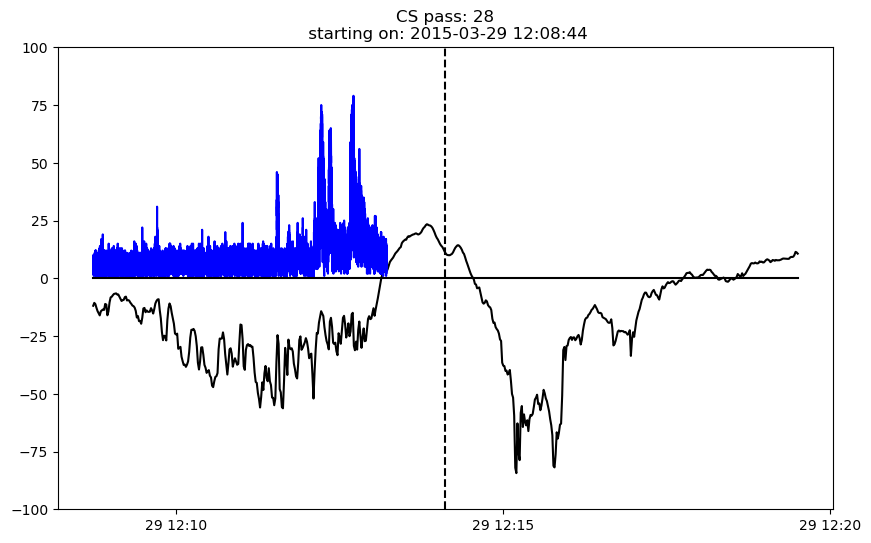

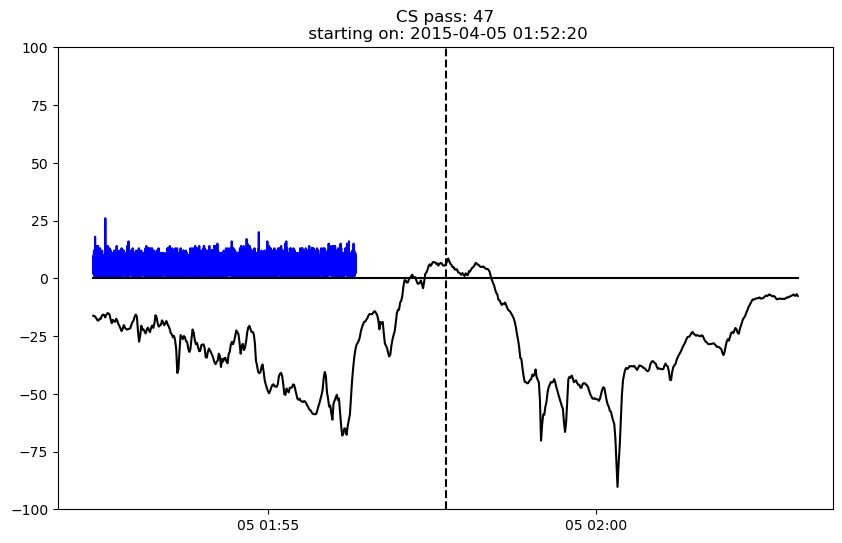

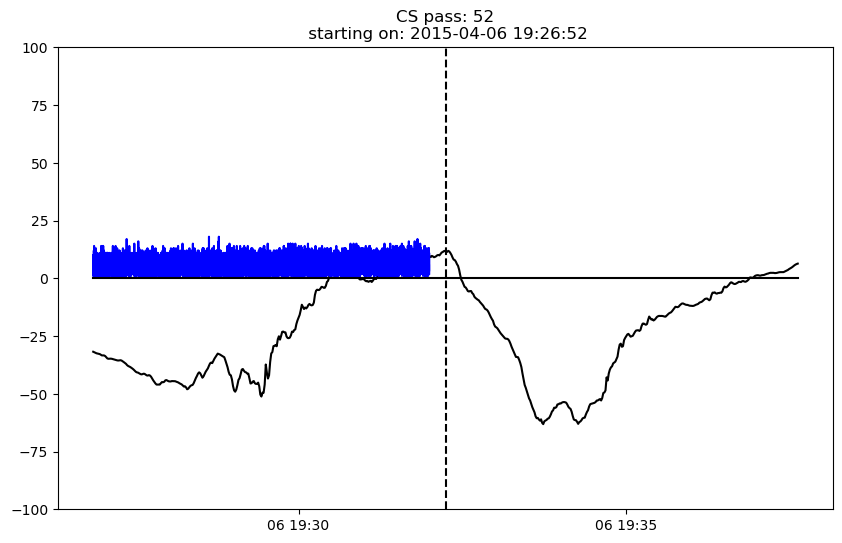

In [10]:
plot_GRS_and_DR(df_cs,GRS,DR_passes)

In [121]:
df_cs["timestamp"][DR_passes[47]]

30617   2015-04-05 01:52:20
30618   2015-04-05 01:52:21
30619   2015-04-05 01:52:22
30620   2015-04-05 01:52:23
30621   2015-04-05 01:52:24
                ...        
31258   2015-04-05 02:03:01
31259   2015-04-05 02:03:02
31260   2015-04-05 02:03:03
31261   2015-04-05 02:03:04
31262   2015-04-05 02:03:05
Name: timestamp, Length: 646, dtype: datetime64[ns]

In [539]:
###SAVE GRS DATA####
#pickle.dump(GRS, open(str(dir+"GRS_data"), 'wb') )
#print("data saved to:",str(dir+"GRS_data"))

data saved to: /Users/atcushen/Documents/MercuryModelling/GRS/GRS_data


Text(0.5, 0, 'Timestamp')

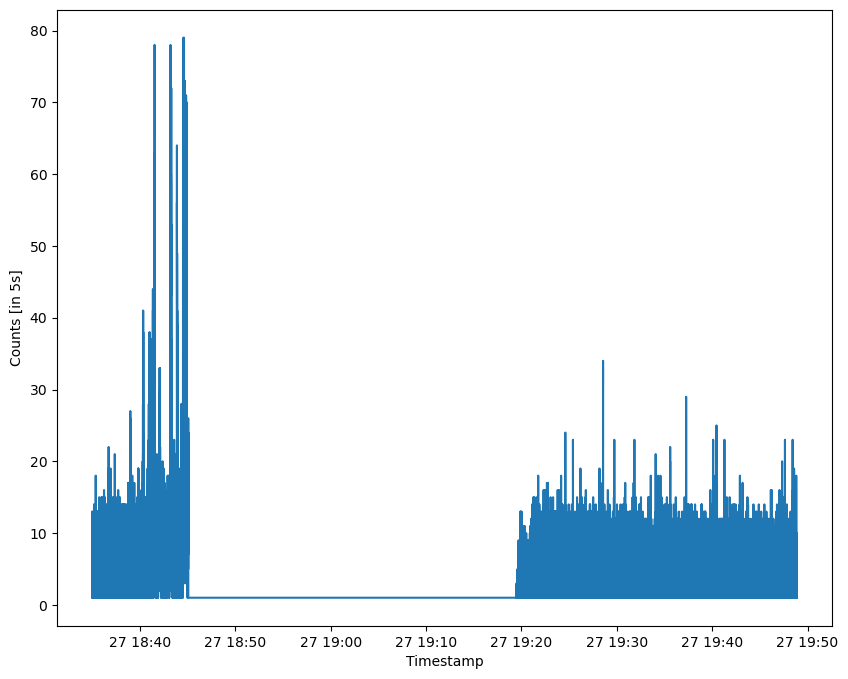

In [11]:
start_time = "2015-03-27 18:35:00"
stop_time = "2015-03-27 19:50:00"
indices = np.where((GRS["timestamp"]>start_time) & (GRS["timestamp"]<stop_time))[0]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
ax.plot(GRS['timestamp'][indices],GRS['counts'][indices])
ax.set_ylabel("Counts [in 5s]")
ax.set_xlabel("Timestamp")

In [22]:
# Load in full time-res magnetometer data
dir = "/Users/atcushen/Documents/MercuryModelling/MAG_highres/"
folder_ls = ["2015-03-27","2015-03-29","2015-04-05","2015-04-06"]

df = read_mag(str(dir+folder_ls[0]),highres=True)
for day in folder_ls[1:]:
    df = pd.concat([df,read_mag(str(dir+day),highres=True)], ignore_index=True)

df_cs = (extract_cs(df,criteria = 'Bx', threshold = 0.5)).reset_index()
df_cs = calculate_terms(df_cs,use_model_data=False)

Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-27
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-29
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-04-05
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-04-06


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12470/3687256897.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['local_time'][df['X']<0] = 24 - df['local_time'][df['X']<0]


Resonance at 0.18: 75.62545682609179 amu
Resonance at 0.18: 73.66658514652173 amu
Resonance at 0.18: 71.04016437869434 amu
Resonance at 0.18: 64.49836713090262 amu


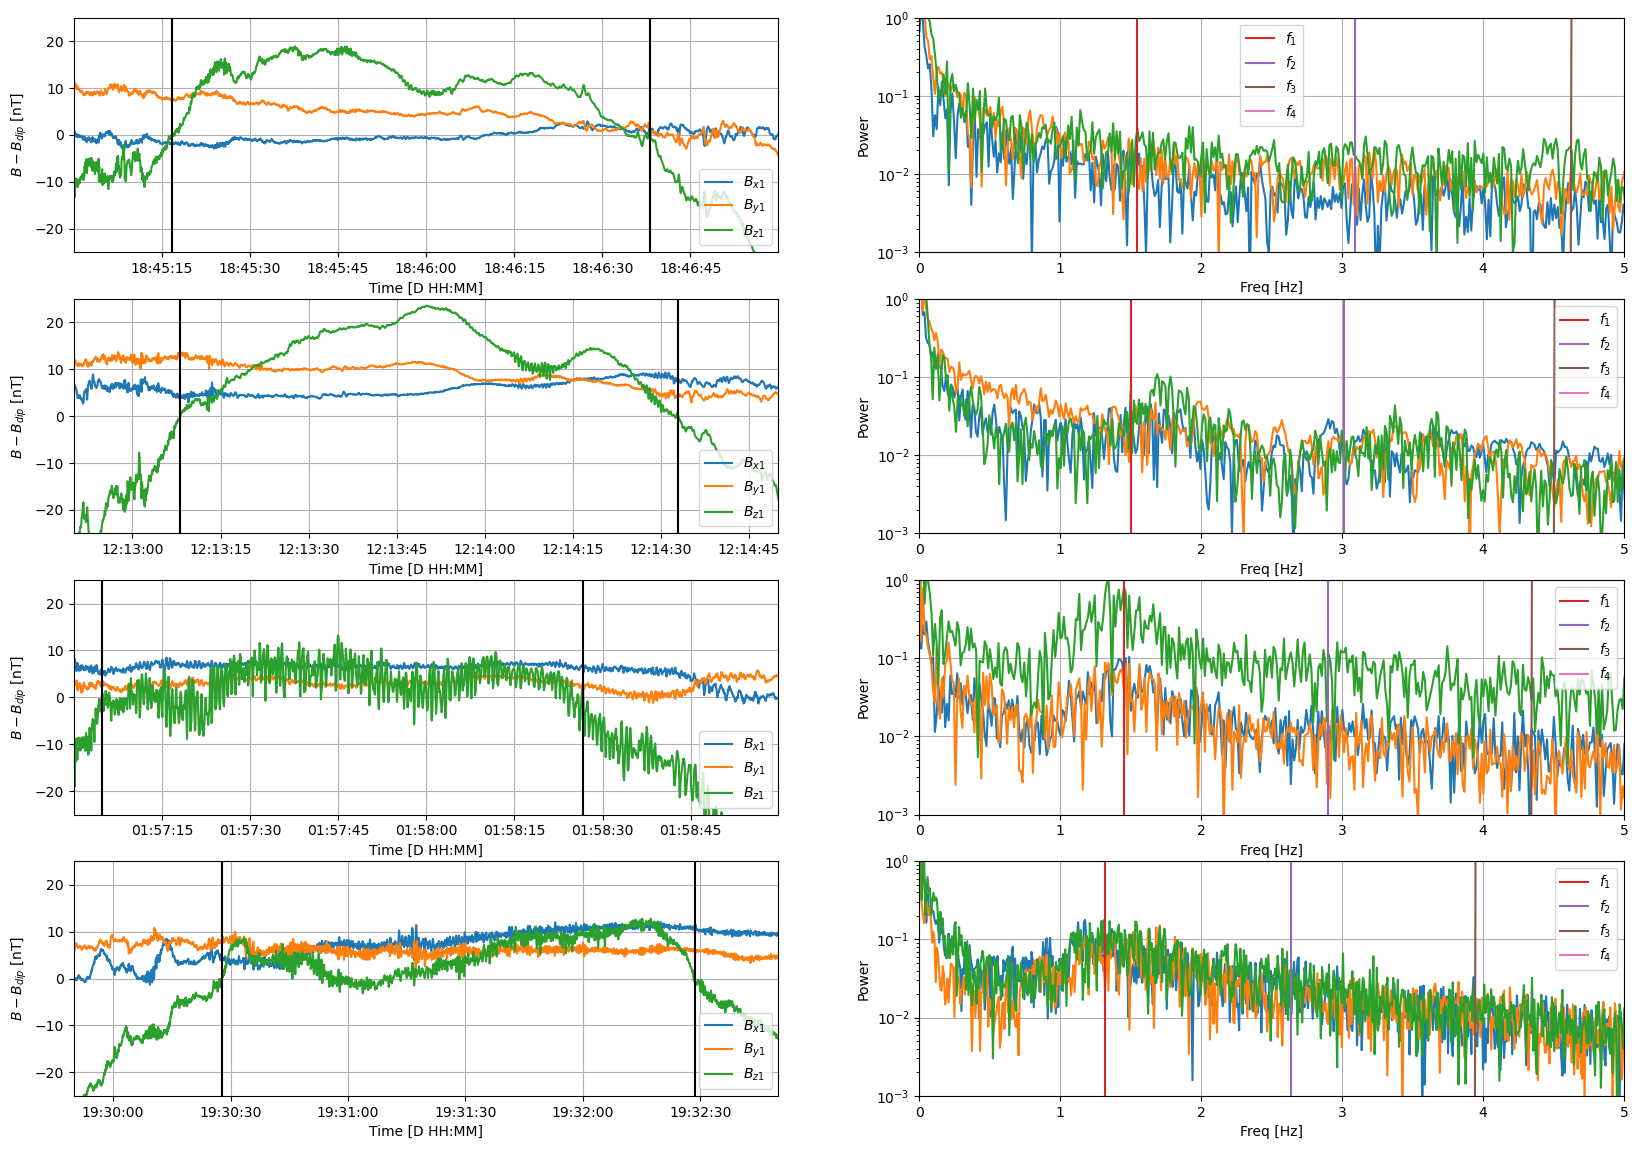

In [116]:
# Compare all events:
# Store start/stop timestamps for CS pass
event_start_times = ["2015-03-27 18:45:00","2015-03-29 12:12:50","2015-04-05 01:57:00", "2015-04-06 19:29:50"]
event_stop_times = ["2015-03-27 18:47:00","2015-03-29 12:14:50","2015-04-05 01:59:00", "2015-04-06 19:32:50"]

# Store start/stop times for flank wave period
wave_start_times = ["2015-03-27 18:45:30","2015-03-29 12:13:20","2015-04-05 01:57:30","2015-04-06 19:31:20"]
wave_stop_times =  ["2015-03-27 18:46:30","2015-03-29 12:14:20","2015-04-05 01:58:30","2015-04-06 19:32:20"]

fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(20,14))
for i in range(len(event_start_times)):
    # Slice out the data
    indices = np.where((df_cs["timestamp"]>event_start_times[i]) & (df_cs["timestamp"]<event_stop_times[i]))[0]
    wave_start = np.where((df_cs["timestamp"]>event_start_times[i]) & (df_cs["B_z"]-df_cs["B_zdip"]>0))[0][0]
    wave_stop = np.where((df_cs["timestamp"]<event_stop_times[i]) & (df_cs["B_z"]-df_cs["B_zdip"]>0))[0][-1]
    Bx = df_cs["B_x"][indices].to_numpy()
    By = df_cs["B_y"][indices].to_numpy()
    Bz = df_cs["B_z"][indices].to_numpy()
    Bmag = df_cs["B_mag"][indices].to_numpy()

    # Plot the mag field data
    #start = pd.to_datetime(wave_start_times[i])
    #stop = pd.to_datetime(wave_stop_times[i])
    start = df_cs["timestamp"][wave_start]
    stop = df_cs["timestamp"][wave_stop]
    #ax[i,0].plot(df_cs["timestamp"][indices],df_cs["B_z"][indices]-df_cs["B_zdip"][indices])
    ax[i,0].plot(df_cs["timestamp"][indices],Bx-df_cs["B_xdip"][indices].to_numpy(),label='$B_{x1}$')
    ax[i,0].plot(df_cs["timestamp"][indices],By-df_cs["B_ydip"][indices].to_numpy(),label='$B_{y1}$')
    ax[i,0].plot(df_cs["timestamp"][indices],Bz-df_cs["B_zdip"][indices].to_numpy(),label='$B_{z1}$')
    #ax[i,0].plot(df_cs["timestamp"][indices],Bmag,label='Bmag')
    #ax[i,0].plot(df_cs["timestamp"][indices],df_cs["B_xdip"][indices],color='tab:blue',linestyle='dashed')
    #ax[i,0].plot(df_cs["timestamp"][indices],df_cs["B_ydip"][indices],color='tab:orange',linestyle='dashed')
    #ax[i,0].plot(df_cs["timestamp"][indices],df_cs["B_zdip"][indices],color='tab:green',linestyle='dashed')
    ax[i,0].plot([start,start],[-1000,1000],color='black')
    ax[i,0].plot([stop,stop],[-1000,1000],color='black')
    ax[i,0].grid()
    ax[i,0].set_xlabel("Time [D HH:MM]")
    ax[i,0].set_ylabel("$B-B_{dip}$ [nT]")
    ax[i,0].set_ylim(-25,25)
    ax[i,0].set_xlim(pd.to_datetime(df_cs["timestamp"][indices[0]]),pd.to_datetime(df_cs["timestamp"][indices[-1]]))
    ax[i,0].legend(loc='lower right')


    # Fourier
    Bx = df_cs["B_x"][wave_start:wave_stop].to_numpy()
    By = df_cs["B_y"][wave_start:wave_stop].to_numpy()
    Bz = df_cs["B_z"][wave_start:wave_stop].to_numpy()
    dt = df_cs["TIME_TAG"][wave_start:wave_stop].to_numpy()[1] - df_cs["TIME_TAG"][wave_start:wave_stop].to_numpy()[0]
    time = df_cs["timestamp"][wave_start:wave_stop].to_numpy()
    sec = np.linspace(0,dt*len(time),len(time))
    N = len(sec)
    freq = fftfreq(N,0.05)[:N//2]
    f_x = fft(Bx-df_cs["B_xdip"][wave_start:wave_stop].to_numpy())
    f_y = fft(By-df_cs["B_ydip"][wave_start:wave_stop].to_numpy())
    f_z = fft(Bz-df_cs["B_zdip"][wave_start:wave_stop].to_numpy())
    #f_a = fft(Bmag)

    # Plot fourier
    ax[i,1].plot(freq,2.0/N * np.abs(f_x[0:N//2]))
    ax[i,1].plot(freq,2.0/N * np.abs(f_y[0:N//2]))
    ax[i,1].plot(freq,2.0/N * np.abs(f_z[0:N//2]))
    #ax[i,1].plot(freq,2.0/N * np.abs(f_a[0:N//2]))
    ax[i,1].set_ylim(0.001,1)
    ax[i,1].set_xlim(0,5)
    ax[i,1].set_ylabel("Power")
    ax[i,1].set_xlabel("Freq [Hz]")
    ax[i,1].set_yscale("log")
    ax[i,1].grid()

    # Add peaks for elements
    Bmag = np.mean(np.sqrt(Bx**2+By**2+Bz**2)*1e-9)
    Bmags = np.array([np.min(np.sqrt(Bx**2+By**2+Bz**2)*1e-9),np.mean(np.sqrt(Bx**2+By**2+Bz**2)*1e-9),np.max(np.sqrt(Bx**2+By**2+Bz**2)*1e-9)])
    H_plus = e*Bmags/(1*amu)
    O_plus = e*Bmags/(16*amu)
    Na_plus = e*Bmags/(23*amu)
    Mg_plus = e*Bmags/(24.3*amu)
    Si_plus = e*Bmags/(28*amu)
    K_plus = e*Bmags/(39*amu)
    Ca_plus = e*Bmags/(40*amu)
    Sr_plus = e*Bmags/(87*amu)
    #ax[i,1].plot([H_plus,H_plus],[0,1e5],label="$H^+$")
    #ax[i,1].plot([O_plus,O_plus],[0,1e5],label="$O^+$")
    #ax[i,1].plot([Na_plus,Na_plus],[0,1e5],label="$Na^+$")
    #ax[i,1].plot([Mg_plus,Mg_plus],[0,1e5],label="$Mg^+$")
    #ax[i,1].plot([Si_plus,Si_plus],[0,1e5],label="$Si^+$")
    #ax[i,1].plot([K_plus,K_plus],[0,1e5],label="$K^+$")
    #ax[i,1].plot([Sr_plus,Sr_plus],[0,1e5],label="$Sr^+$")

    # Plot sodium ion cyclotron harmonics
    #ax[i,1].axvspan(Na_plus[0],Na_plus[2],label="$Na^+_1$",alpha=0.5)
    #ax[i,1].axvspan(2*Na_plus[0],2*Na_plus[2],label="$Na^+_2$",alpha=0.5)
    #ax[i,1].axvspan(3*Na_plus[0],3*Na_plus[2],label="$Na^+_3$",alpha=0.5)
    #ax[i,1].axvspan(4*Na_plus[0],4*Na_plus[2],label="$Na^+_4$",alpha=0.5)
    #ax[i,1].axvspan(5*Na_plus[0],5*Na_plus[2],label="$Na^+_5$",alpha=0.5)

    
    # Plot field line standing wave; assuming rho = 1 amu/cc
    V_A = Bmag/np.sqrt(mu_0*1e6*m_p*0.3) 
    L = 1.5*R_M*1e3
    f1 = V_A / (L)
    f2 = V_A / (1/2*L)
    f3 = V_A / (1/3*L)
    f4 = V_A / (1/4*L)
    ax[i,1].plot([f1,f1],[0,1e5],label="$f_1$")
    ax[i,1].plot([f2,f2],[0,1e5],label="$f_2$")
    ax[i,1].plot([f2,f3],[0,1e5],label="$f_3$")
    ax[i,1].plot([f4,f4],[0,1e5],label="$f_4$")
#
    ax[i,1].legend()

    print("Resonance at 0.18:",(e*Bmag/(0.18))/amu,"amu")

plt.savefig(str("fourier.png"), dpi=300, bbox_inches='tight')


In [106]:
Bmags[1]

1.3899027242580683e-07

Resonance at 0.18: 38.969610619263925 amu
Resonance at 0.18: 39.1404979224644 amu
Resonance at 0.18: 46.61182316650426 amu
Resonance at 0.18: 47.45613324894325 amu


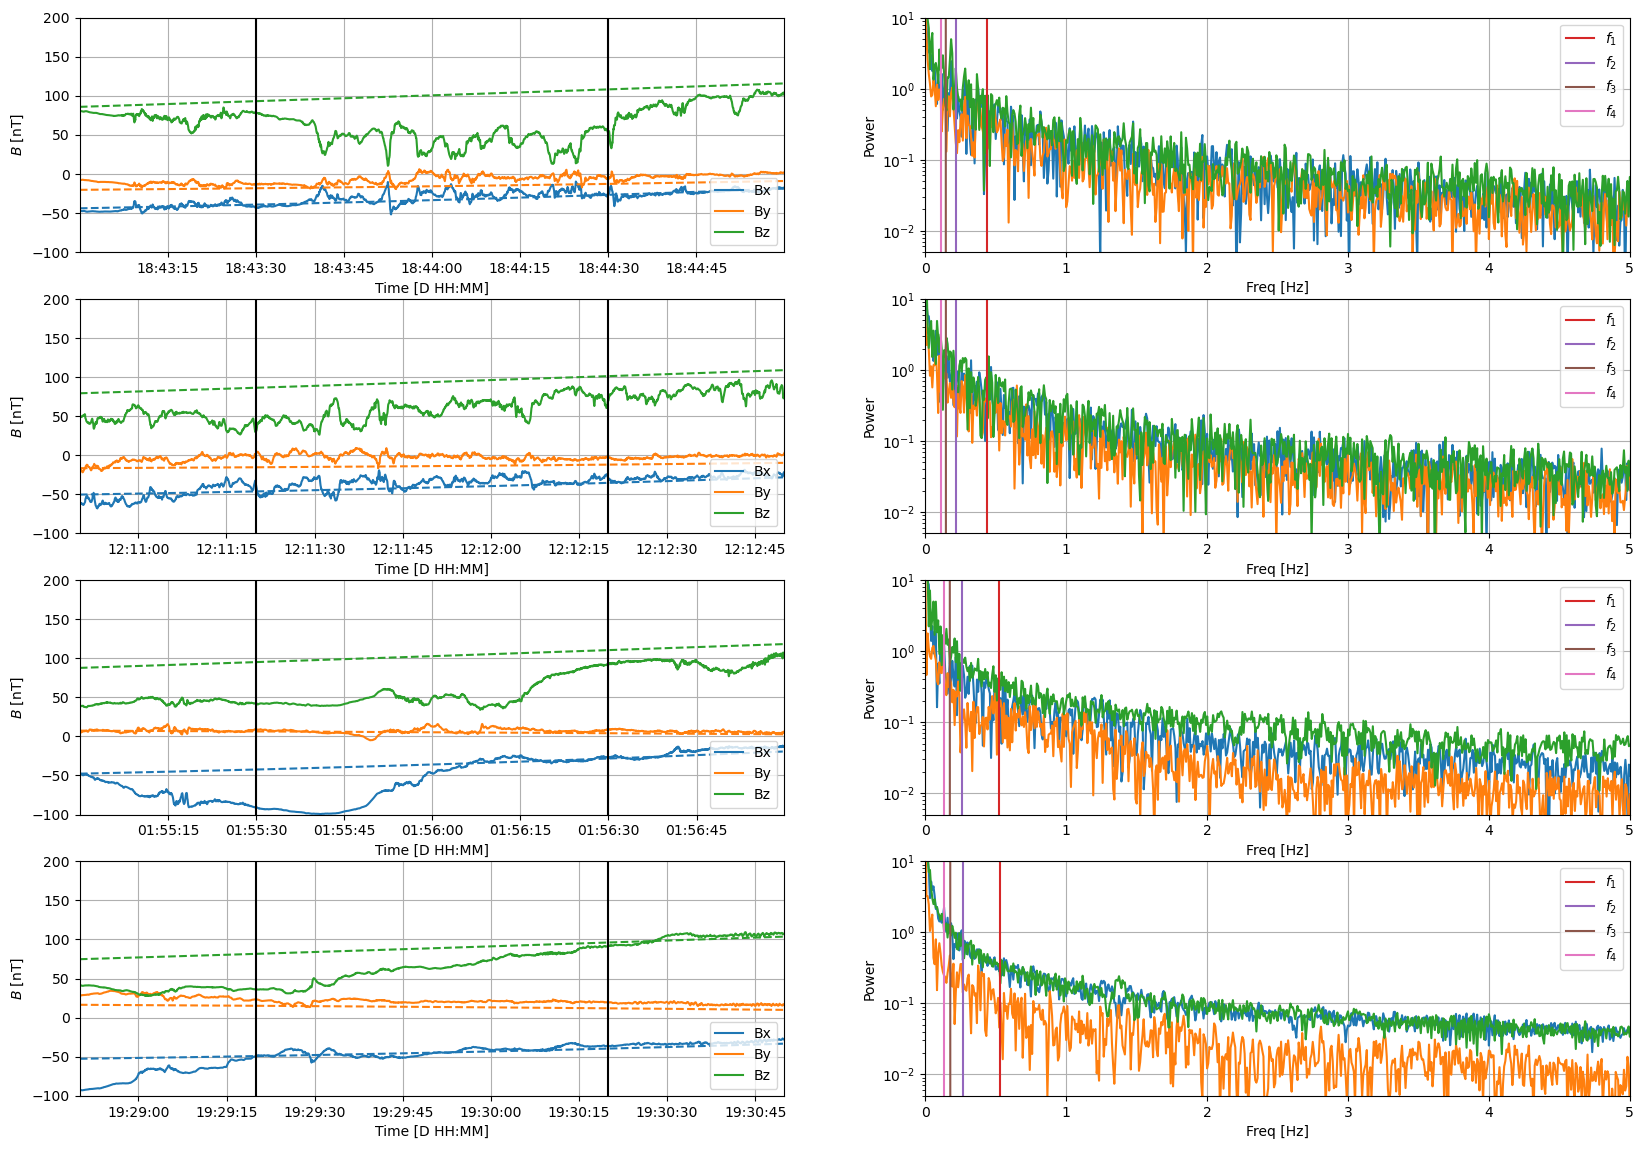

In [55]:
# Compare all events:
# Store start/stop timestamps for CS pass
event_start_times = ["2015-03-27 18:43:00","2015-03-29 12:10:50","2015-04-05 01:55:00", "2015-04-06 19:28:50"]
event_stop_times = ["2015-03-27 18:45:00","2015-03-29 12:12:50","2015-04-05 01:57:00", "2015-04-06 19:30:50"]

# Store start/stop times for flank wave period
wave_start_times = ["2015-03-27 18:43:30","2015-03-29 12:11:20","2015-04-05 01:55:30","2015-04-06 19:29:20"]
wave_stop_times =  ["2015-03-27 18:44:30","2015-03-29 12:12:20","2015-04-05 01:56:30","2015-04-06 19:30:20"]

fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(20,14))
for i in range(len(event_start_times)):
    # Slice out the data
    indices = np.where((df_cs["timestamp"]>event_start_times[i]) & (df_cs["timestamp"]<event_stop_times[i]))[0]
    Bx = df_cs["B_x"][indices].to_numpy()
    By = df_cs["B_y"][indices].to_numpy()
    Bz = df_cs["B_z"][indices].to_numpy()

    # Plot the mag field data
    start = pd.to_datetime(wave_start_times[i])
    stop = pd.to_datetime(wave_stop_times[i])
    #ax[i,0].plot(df_cs["timestamp"][indices],df_cs["B_z"][indices]-df_cs["B_zdip"][indices])
    ax[i,0].plot(df_cs["timestamp"][indices],Bx,label='Bx')
    ax[i,0].plot(df_cs["timestamp"][indices],By,label='By')
    ax[i,0].plot(df_cs["timestamp"][indices],Bz,label='Bz')
    ax[i,0].plot(df_cs["timestamp"][indices],df_cs["B_xdip"][indices],color='tab:blue',linestyle='dashed')
    ax[i,0].plot(df_cs["timestamp"][indices],df_cs["B_ydip"][indices],color='tab:orange',linestyle='dashed')
    ax[i,0].plot(df_cs["timestamp"][indices],df_cs["B_zdip"][indices],color='tab:green',linestyle='dashed')
    ax[i,0].plot([start,start],[-1000,1000],color='black')
    ax[i,0].plot([stop,stop],[-1000,1000],color='black')
    ax[i,0].grid()
    ax[i,0].set_xlabel("Time [D HH:MM]")
    ax[i,0].set_ylabel("$B$ [nT]")
    ax[i,0].set_ylim(-100,200)
    ax[i,0].set_xlim(pd.to_datetime(df_cs["timestamp"][indices[0]]),pd.to_datetime(df_cs["timestamp"][indices[-1]]))
    ax[i,0].legend(loc='lower right')


    # Fourier
    dt = df_cs["TIME_TAG"][indices].to_numpy()[1] - df_cs["TIME_TAG"][indices].to_numpy()[0]
    time = df_cs["timestamp"][indices].to_numpy()
    sec = np.linspace(0,dt*len(time),len(time))
    N = len(sec)
    freq = fftfreq(N,0.05)[:N//2]
    f_x = fft(Bx)
    f_y = fft(By)
    f_z = fft(Bz)

    # Plot fourier
    ax[i,1].plot(freq,2.0/N * np.abs(f_x[0:N//2]))
    ax[i,1].plot(freq,2.0/N * np.abs(f_y[0:N//2]))
    ax[i,1].plot(freq,2.0/N * np.abs(f_z[0:N//2]))
    ax[i,1].set_ylim(0.005,10)
    ax[i,1].set_xlim(0,5)
    ax[i,1].set_ylabel("Power")
    ax[i,1].set_xlabel("Freq [Hz]")
    ax[i,1].set_yscale("log")
    ax[i,1].grid()

    # Add peaks for elements
    Bmag = np.mean(np.sqrt(Bx**2+By**2+Bz**2)*1e-9)
    O_plus = e*Bmag/(16*amu)
    Na_plus = e*Bmag/(23*amu)
    Mg_plus = e*Bmag/(24.3*amu)
    Si_plus = e*Bmag/(28*amu)
    K_plus = e*Bmag/(39*amu)
    Ca_plus = e*Bmag/(40*amu)
    Sr_plus = e*Bmag/(87*amu)
    #ax[i,1].plot([O_plus,O_plus],[0,1e5],label="$O^+$")
    #ax[i,1].plot([Na_plus,Na_plus],[0,1e5],label="$Na^+$")
    #ax[i,1].plot([Mg_plus,Mg_plus],[0,1e5],label="$Mg^+$")
    #ax[i,1].plot([Si_plus,Si_plus],[0,1e5],label="$Si^+$")
    #ax[i,1].plot([K_plus,K_plus],[0,1e5],label="$K^+$")
    #ax[i,1].plot([Sr_plus,Sr_plus],[0,1e5],label="$Sr^+$")

    # Plot field line standing wave; assuming rho = 1 amu/cc
    V_A = Bmag/np.sqrt(mu_0*1e6*m_p) 
    L = 1.5*R_M*1e3
    f1 = V_A / (L)
    f2 = V_A / (2*L)
    f3 = V_A / (3*L)
    f4 = V_A / (4*L)
    ax[i,1].plot([f1,f1],[0,1e5],label="$f_1$")
    ax[i,1].plot([f2,f2],[0,1e5],label="$f_2$")
    ax[i,1].plot([f2,f3],[0,1e5],label="$f_3$")
    ax[i,1].plot([f4,f4],[0,1e5],label="$f_4$")
#
    ax[i,1].legend()

    print("Resonance at 0.18:",(e*Bmag/(0.18))/amu,"amu")

plt.savefig(str("fourier.png"), dpi=300, bbox_inches='tight')
